In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import f1_score
from tqdm import tqdm
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt 

In [2]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Focal Loss для решения проблемы дисбаланса классов.
        :param alpha: Веса классов. Если None, все классы считаются равноважными.
        :param gamma: Фокусирующий параметр. Чем выше gamma, тем больше фокус на сложных примерах.
        :param reduction: Способ агрегации потерь ('none', 'mean', 'sum').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Применяем логит к целям
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)  # Вероятность предсказания правильного класса
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

# Отображение строковых меток в числовые
label_mapping_quality = {
    'false': 0,
    'man_doing_something': 1,
    'true': 2
}
label_mapping_count = {
    'Down': 0,
    'Up': 1
}

# ===================== Датасет =====================
class PushupPoseDatasetFromDF(Dataset):
    def __init__(self, df, seq_len, num_joints=133, normalize=True):
        self.df = df.reset_index(drop=True)
        self.seq_len = seq_len
        self.num_joints = num_joints
        self.normalize = normalize

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        skeleton_path = row['skeleton_file']
        video_path = row['video_path']
        file_name = os.path.basename(video_path)

        # Загружаем последовательность скелета
        skeleton_seq = np.load(skeleton_path, allow_pickle=True)
        T, K, C = skeleton_seq.shape

        # Приводим к нужному числу ключевых точек
        if K != self.num_joints or C != 2:
            if K < self.num_joints:
                pad = np.zeros((T, self.num_joints - K, 2), dtype=skeleton_seq.dtype)
                skeleton_seq = np.concatenate([skeleton_seq, pad], axis=1)
            else:
                skeleton_seq = skeleton_seq[:, :self.num_joints, :2]

        # Дополняем последовательность до нужной длины
        if T < self.seq_len:
            pad_frames = np.zeros((self.seq_len - T, self.num_joints, 2), dtype=skeleton_seq.dtype)
            skeleton_seq = np.concatenate([skeleton_seq, pad_frames], axis=0)
        else:
            skeleton_seq = skeleton_seq[:self.seq_len]

        # # Нормализация
        if self.normalize:
            skeleton_seq = skeleton_seq / 1000.0

        data_tensor = torch.tensor(skeleton_seq, dtype=torch.float32)

        # Получаем метку качества
        quality_label_str = row['label']
        quality_label = label_mapping_quality[quality_label_str]

        # print(file_name)
        if  quality_label_str == "man_doing_something":
             count_label = 2  # В случае, если нет данных 
        else:
            # Извлекаем класс из названия видео
            if 'спуск' in file_name:
                count_label = label_mapping_count['Down']
            elif 'подъем' in file_name:
                count_label = label_mapping_count['Up']


        return data_tensor, quality_label, count_label


In [4]:
train_csv_path = r"C:\Users\jet\Desktop\видосы\np\2vr_5\skeletons_train\skeleton_records_train.csv"
val_csv_path = r"C:\Users\jet\Desktop\видосы\np\2vr_5\skeletons_val\skeleton_records_val.csv"
train_df = pd.read_csv(train_csv_path)
val_df   = pd.read_csv(val_csv_path)
seq_len =  2
num_joints = 17
batch_size = 128
num_epochs = 200

# # Датасеты и DataLoader:
train_dataset = PushupPoseDatasetFromDF(train_df, seq_len=seq_len, num_joints=num_joints, normalize=True)
val_dataset   = PushupPoseDatasetFromDF(val_df, seq_len=seq_len, num_joints=num_joints, normalize=True)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

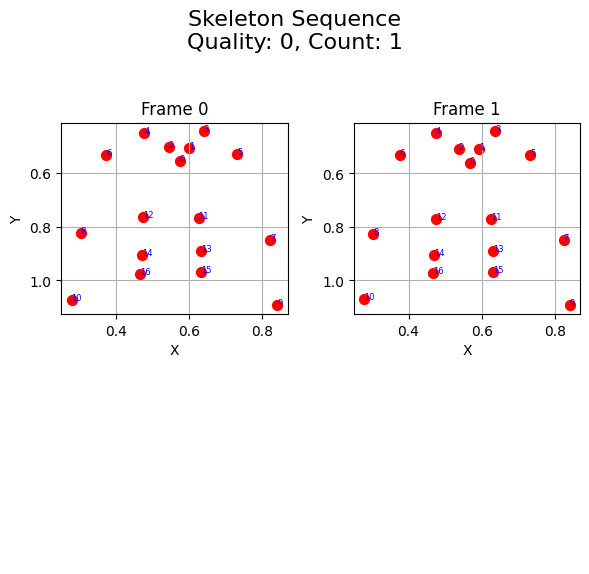

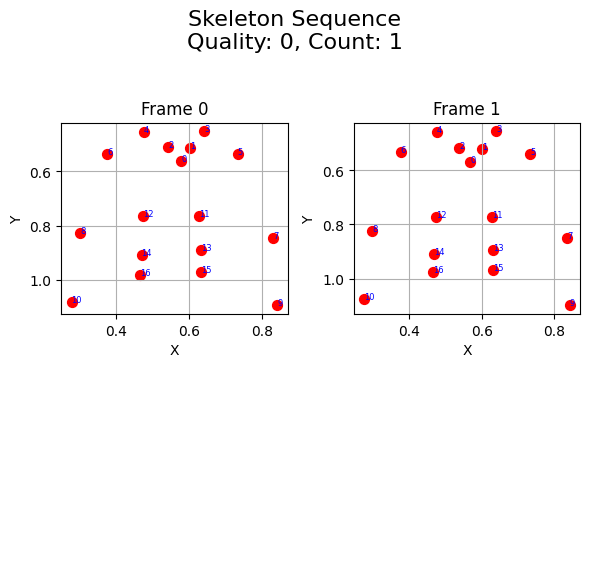

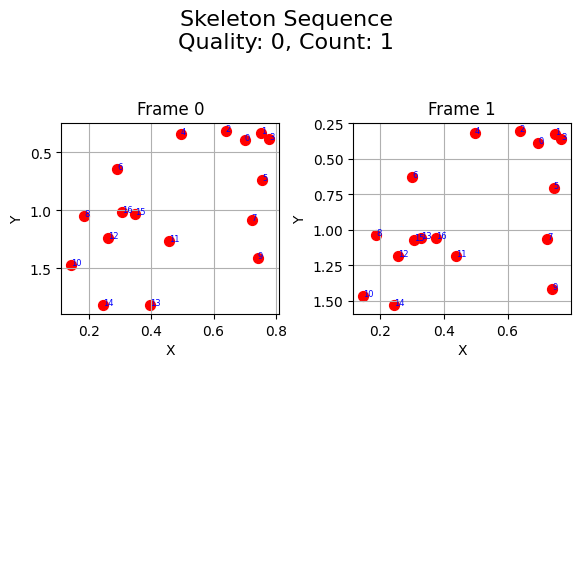

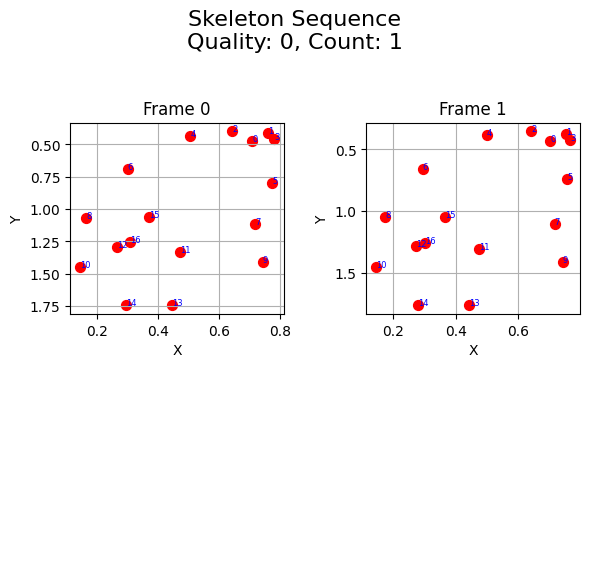

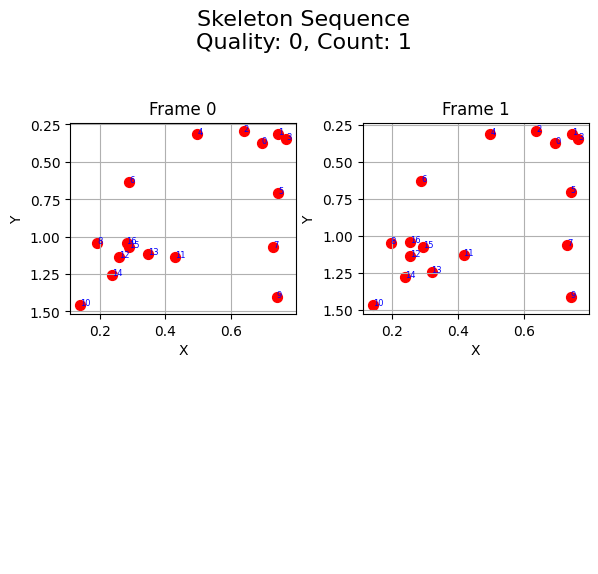

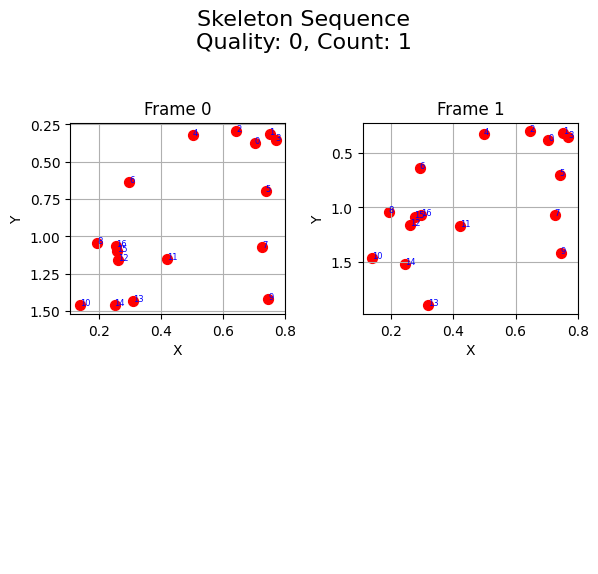

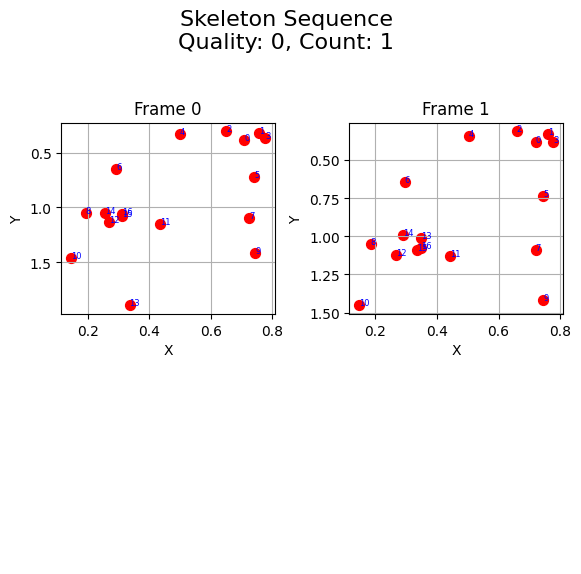

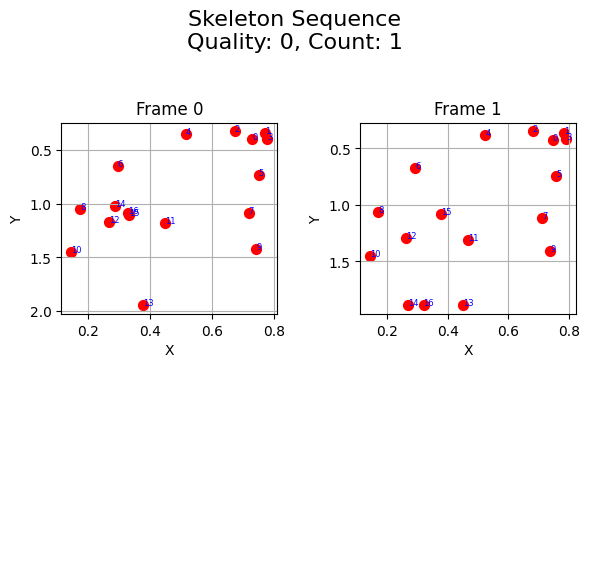

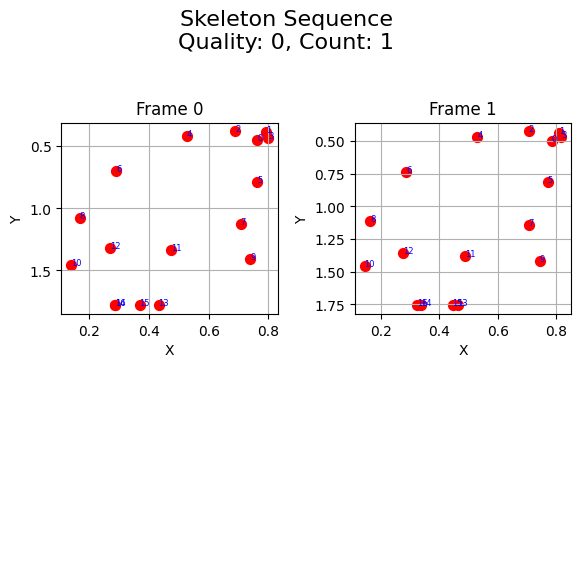

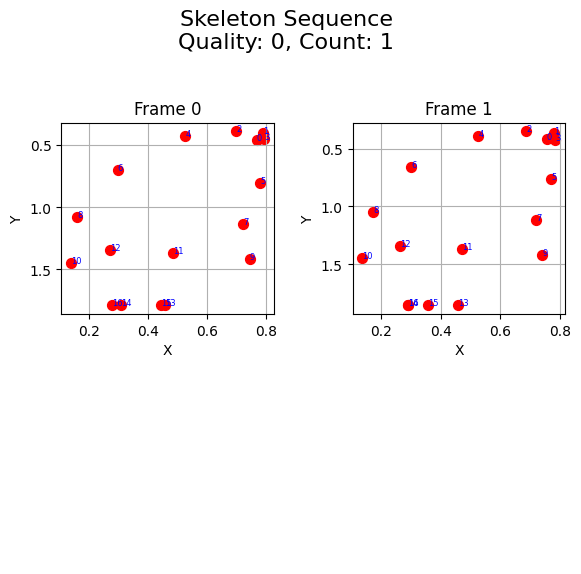

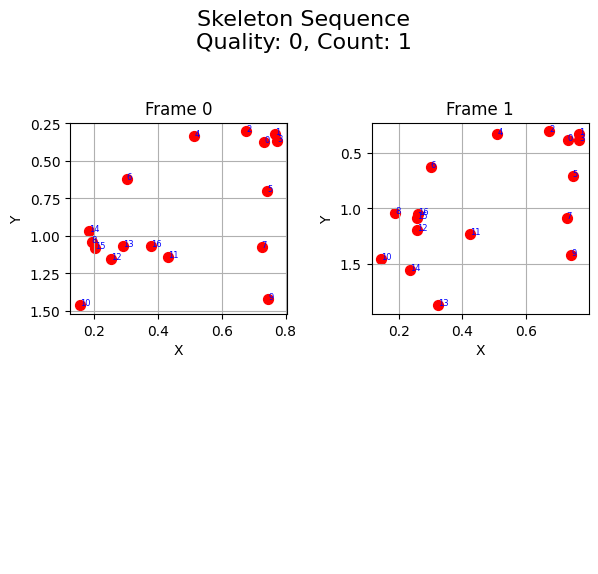

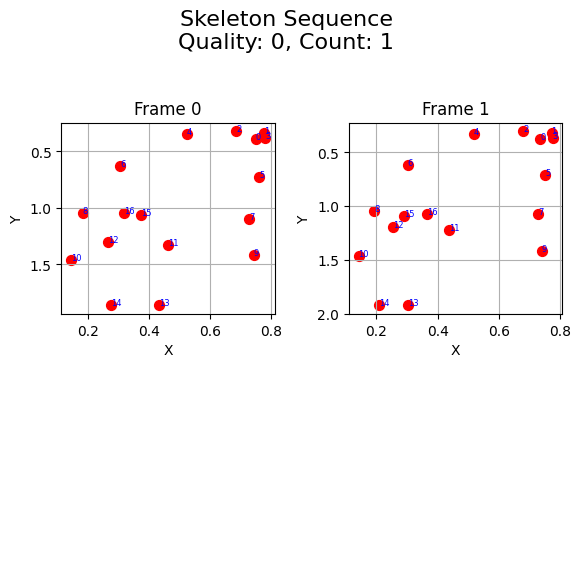

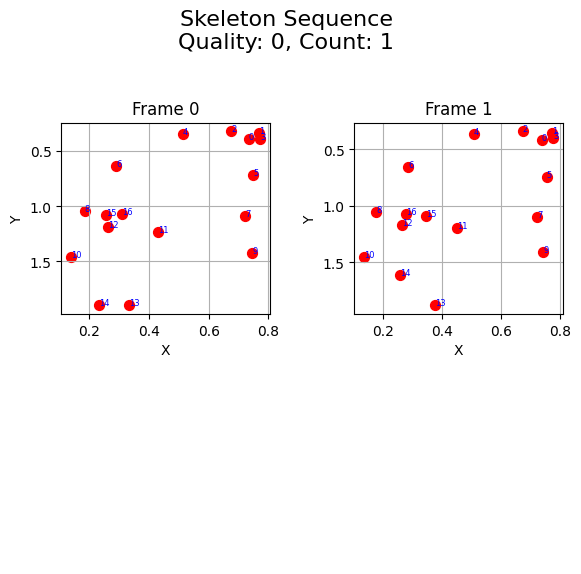

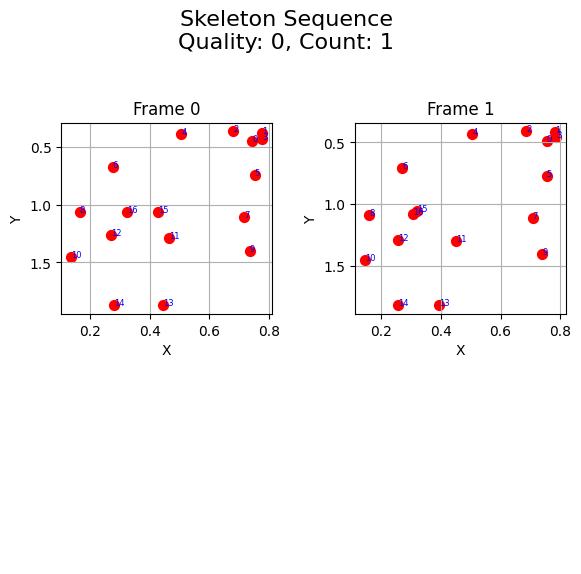

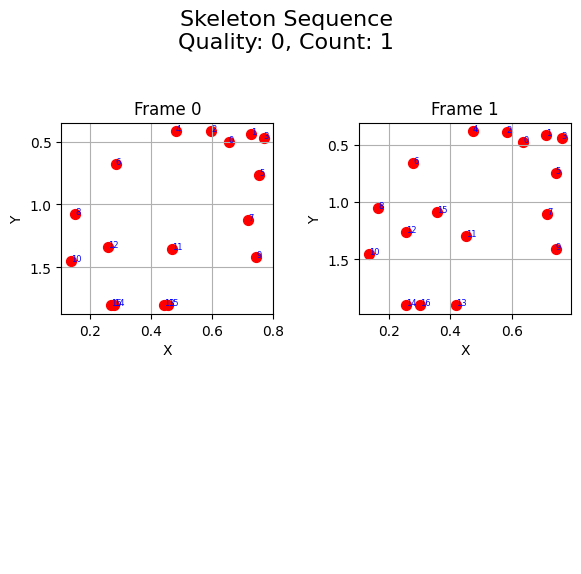

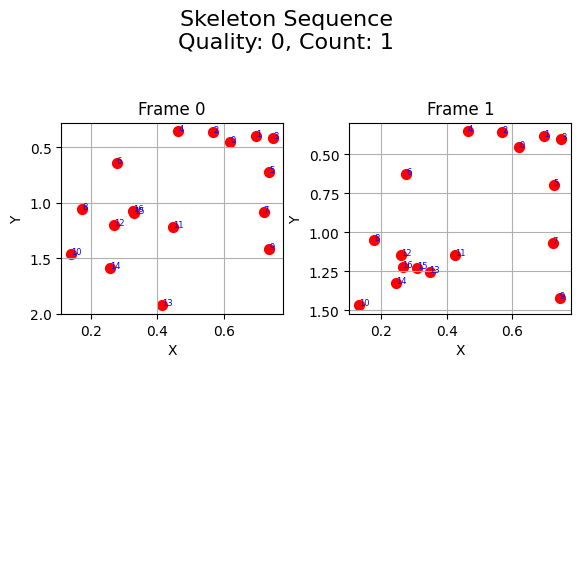

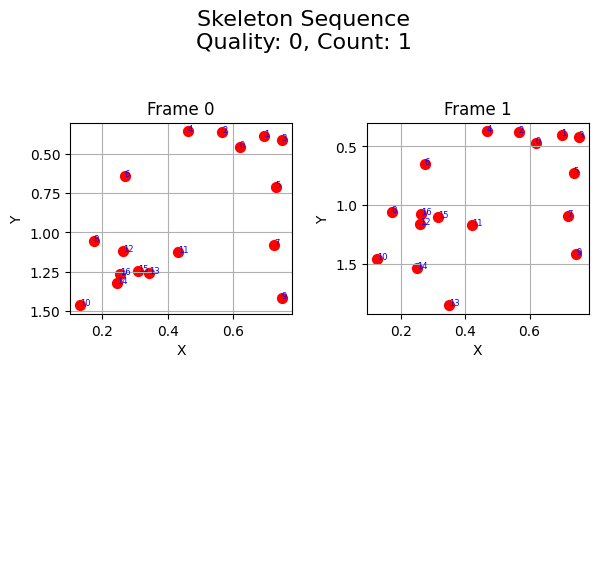

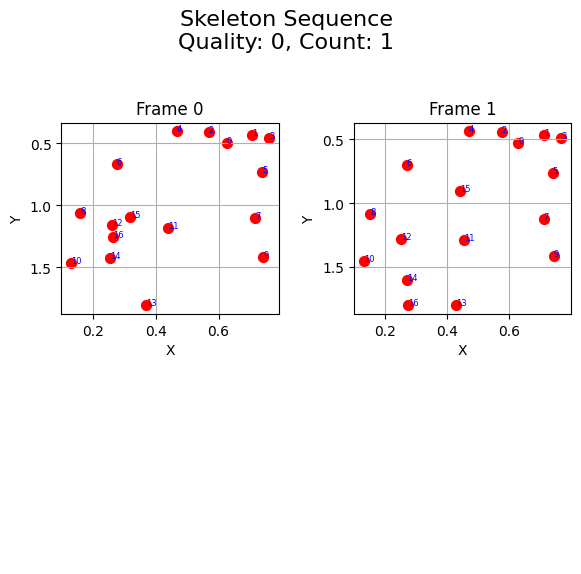

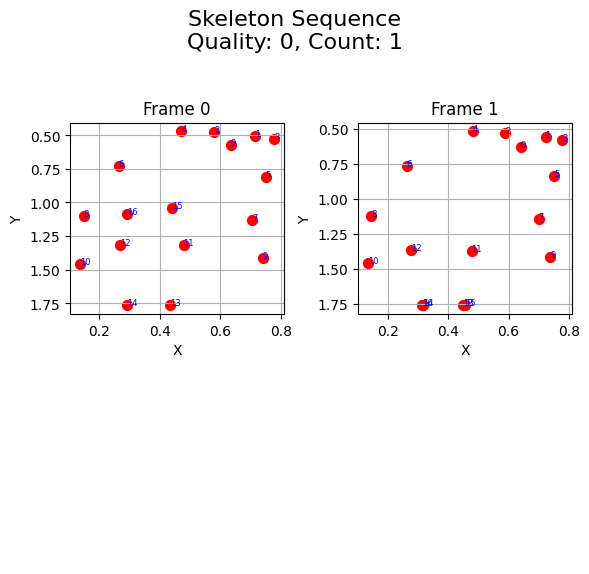

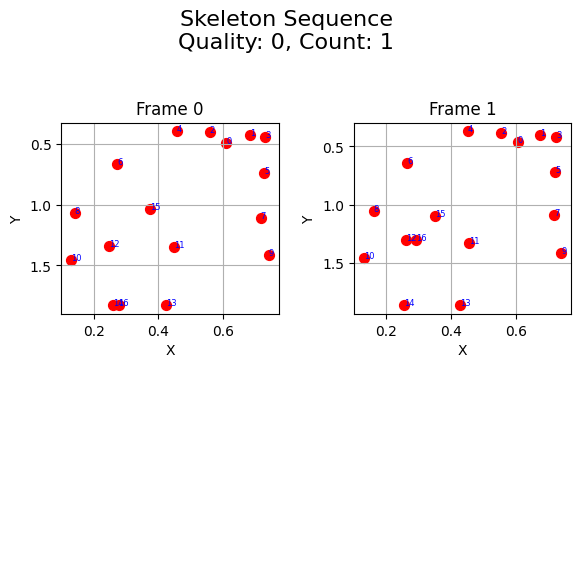

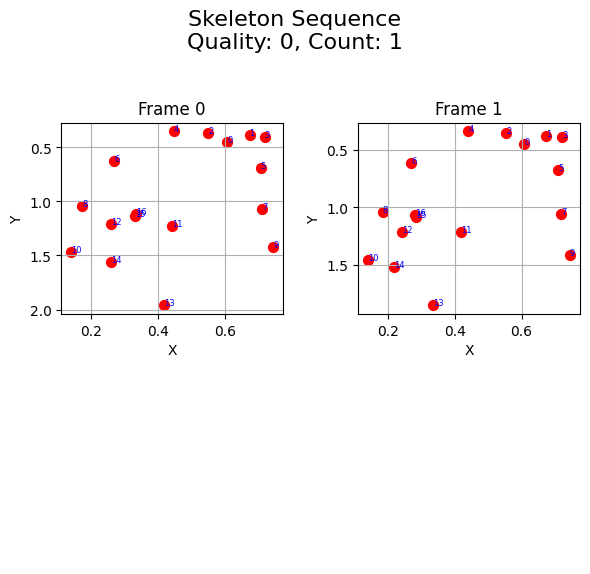

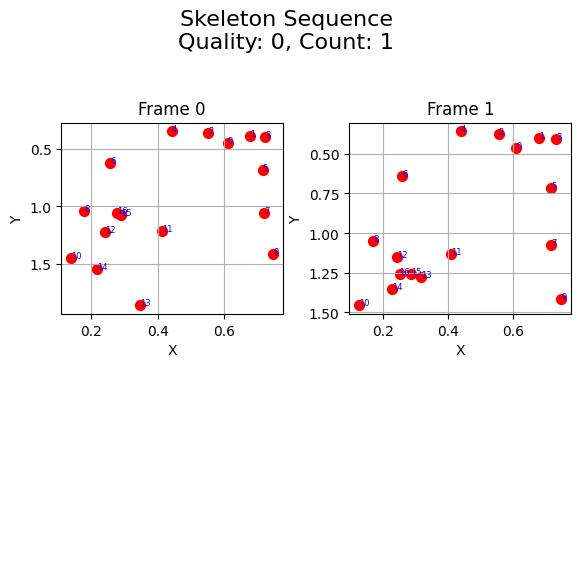

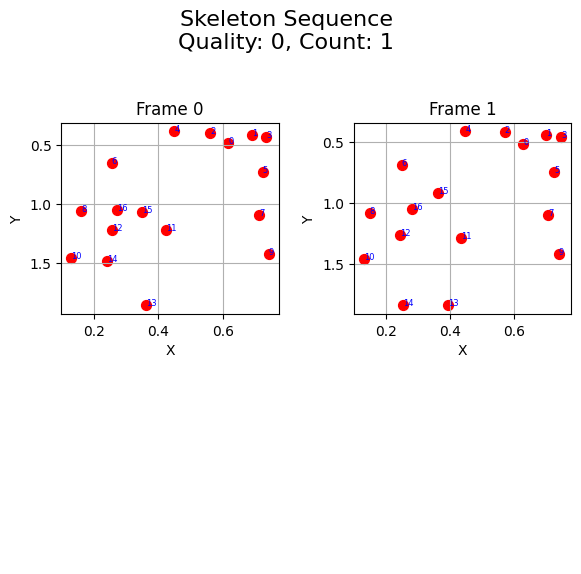

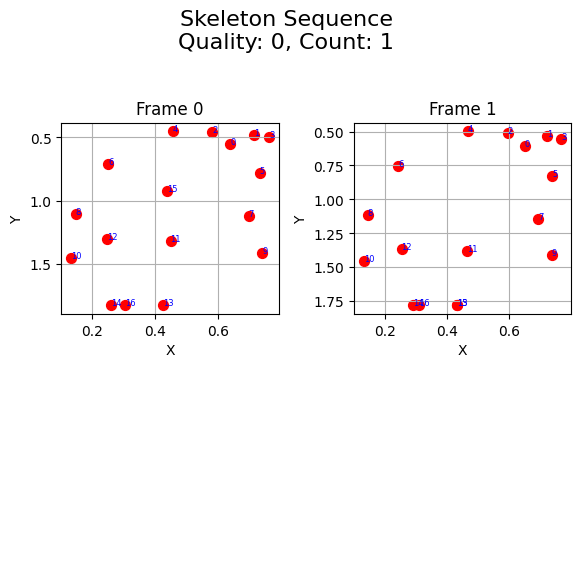

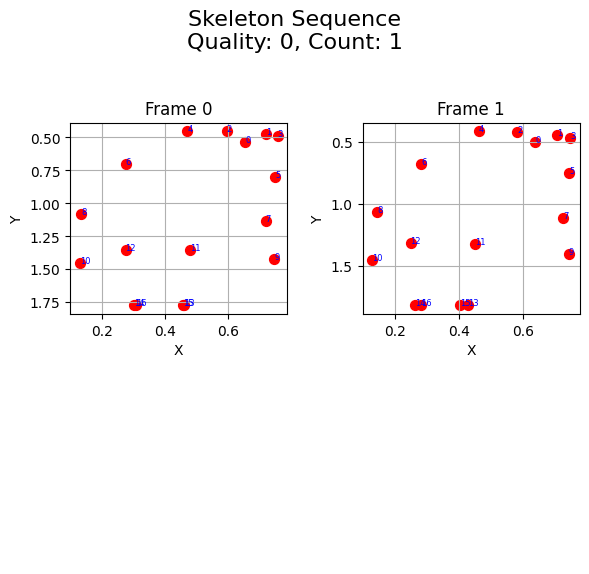

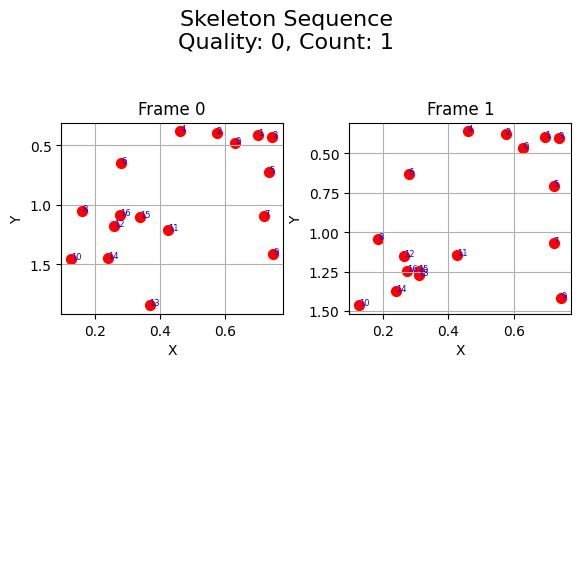

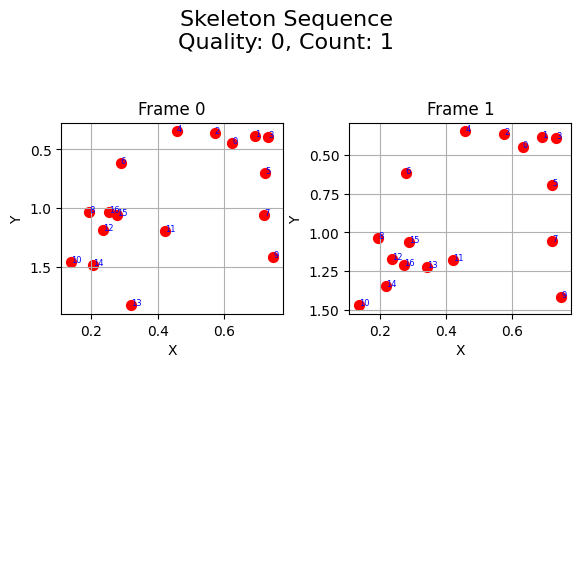

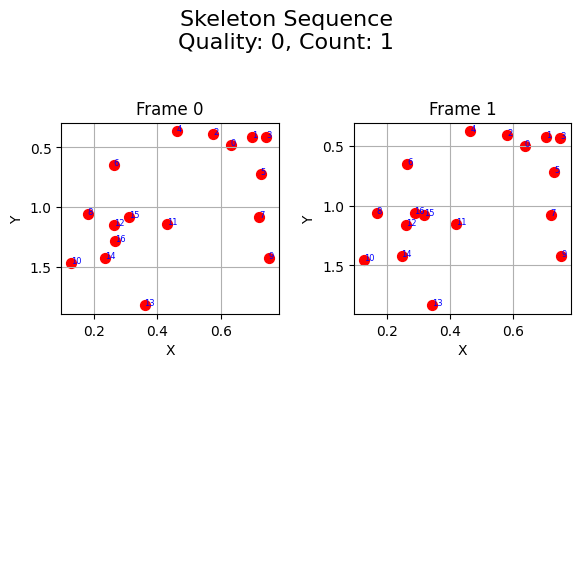

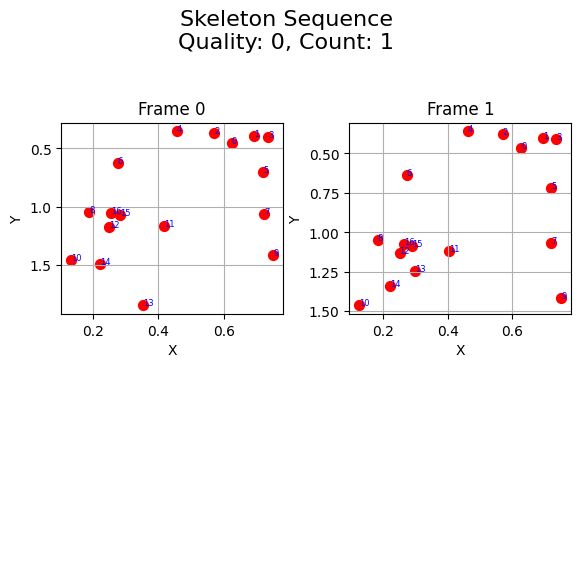

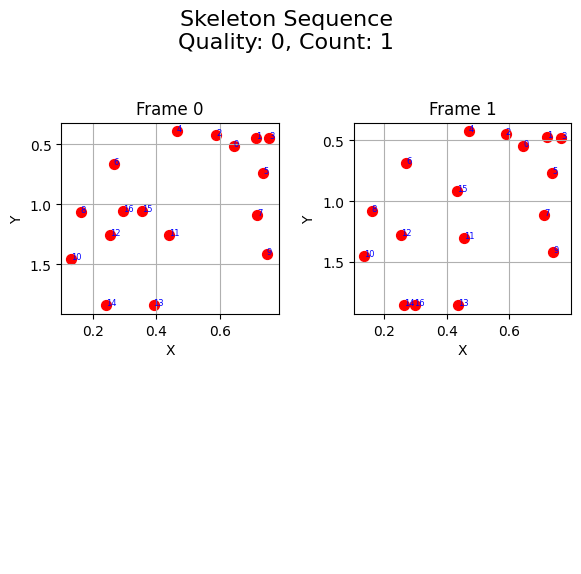

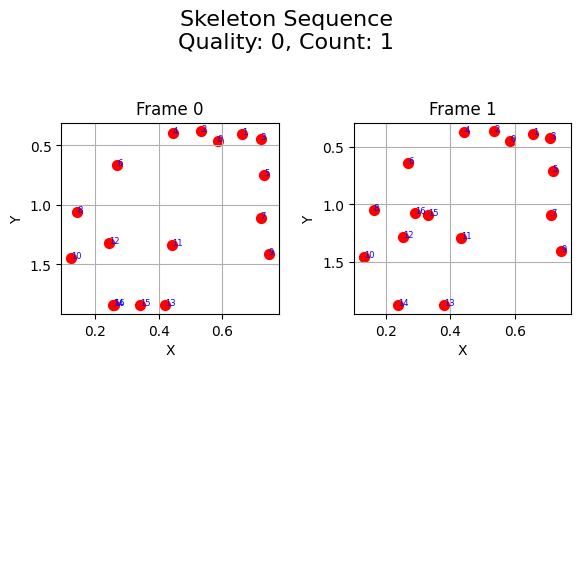

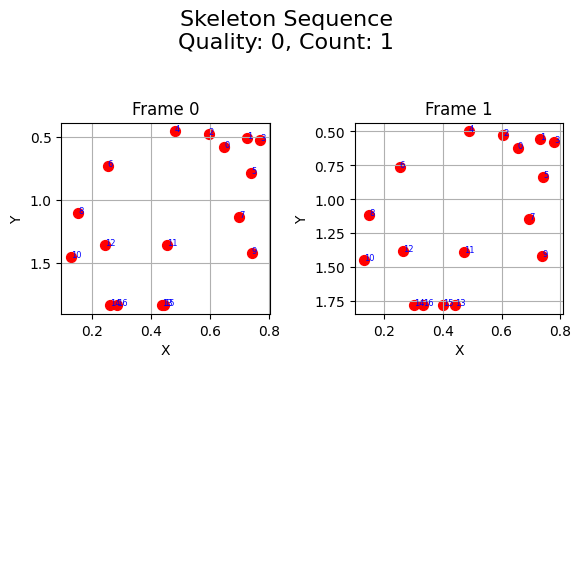

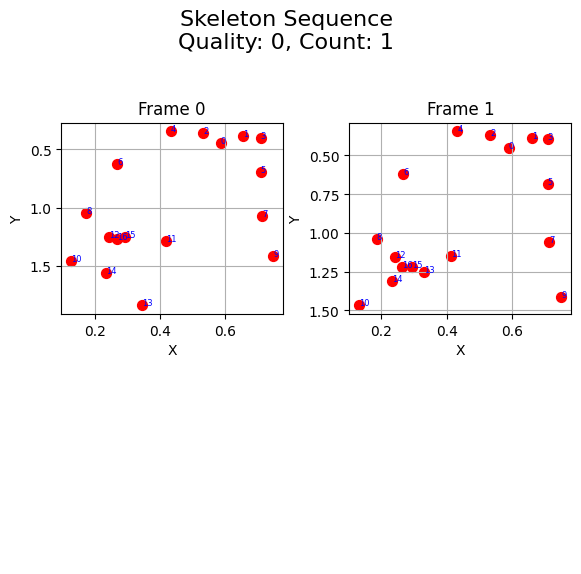

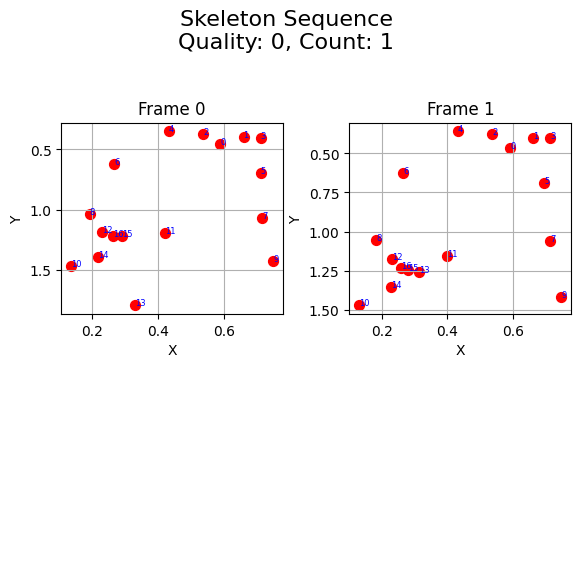

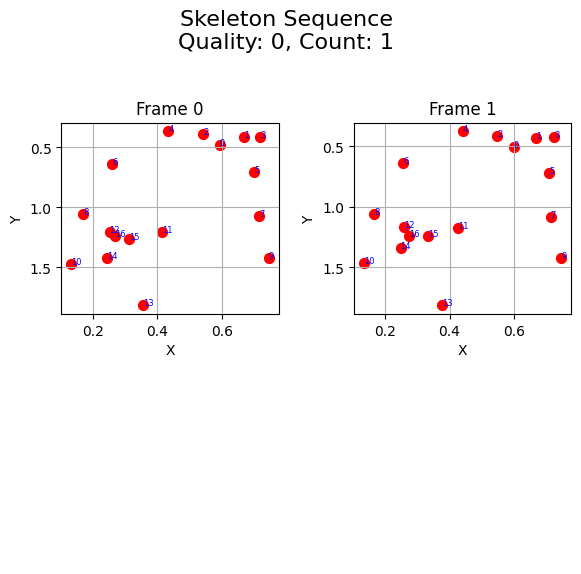

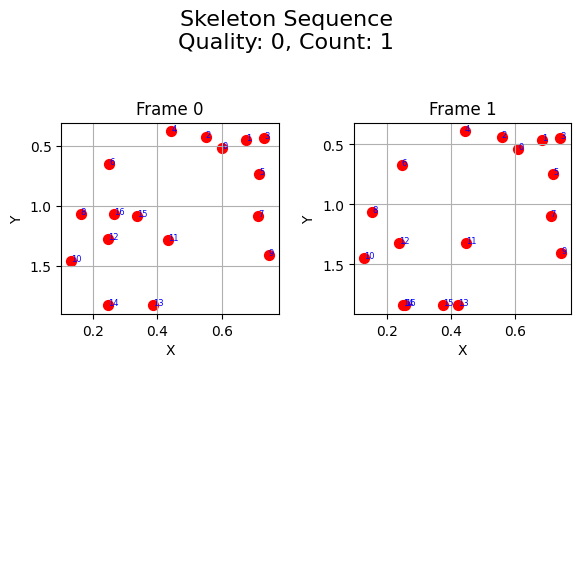

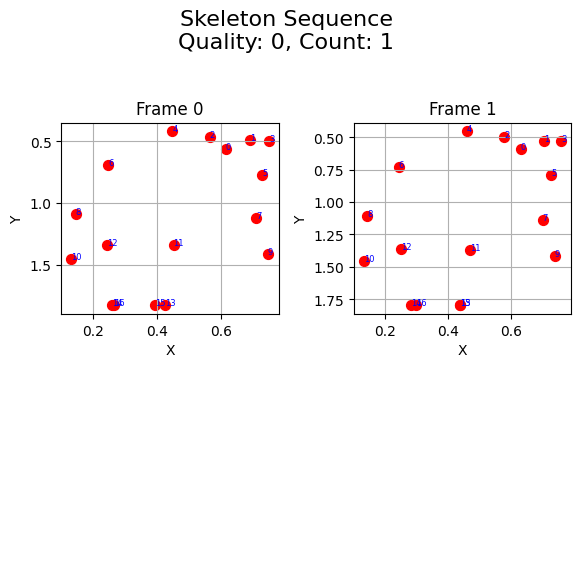

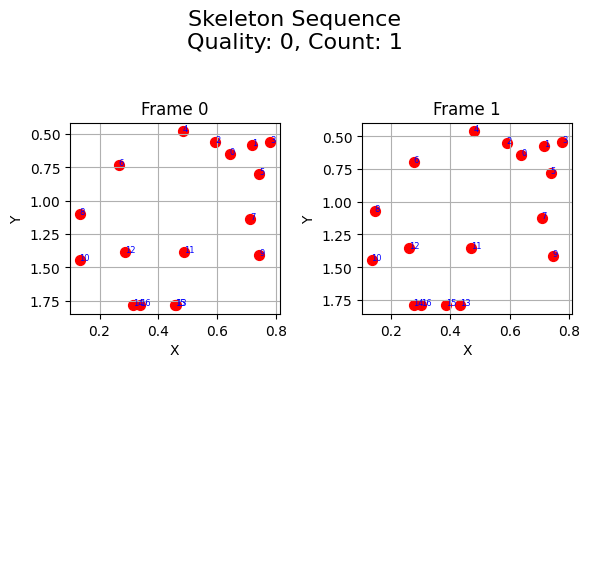

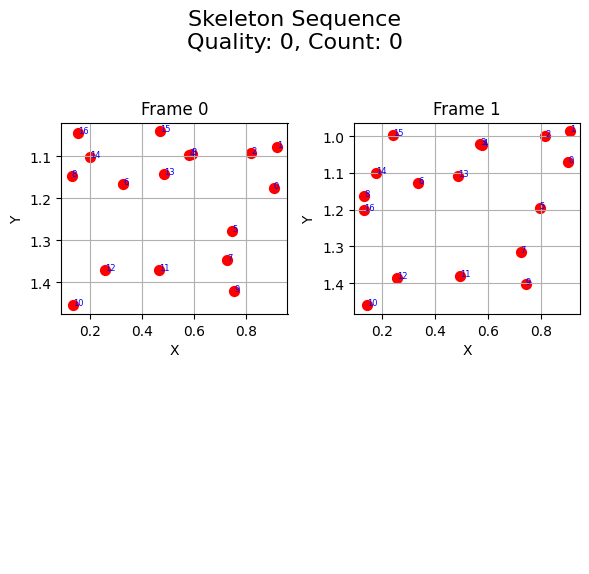

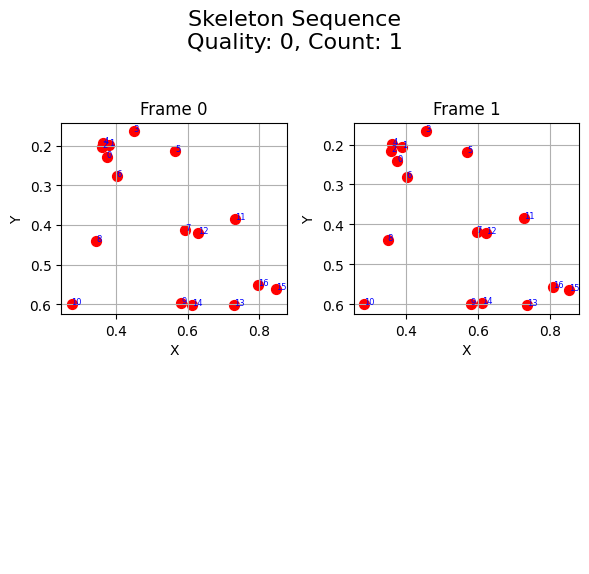

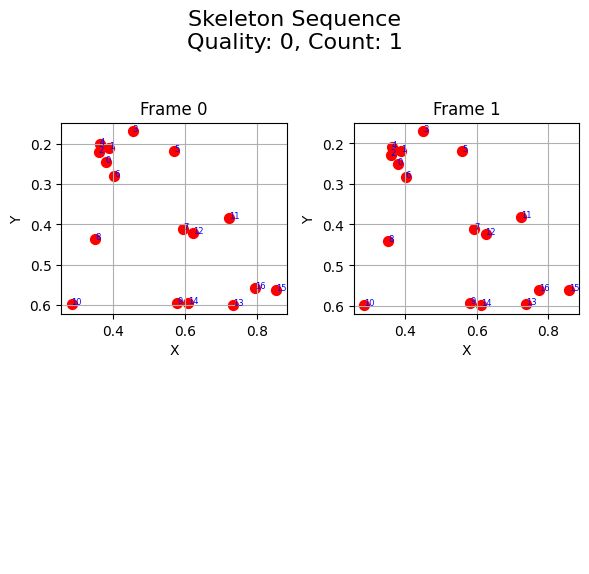

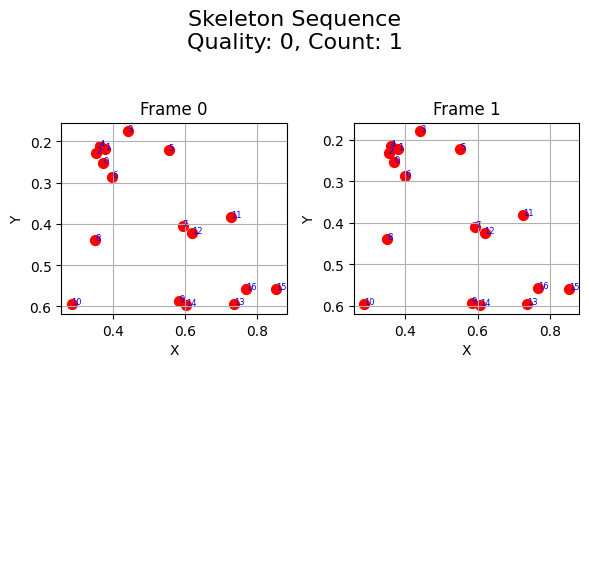

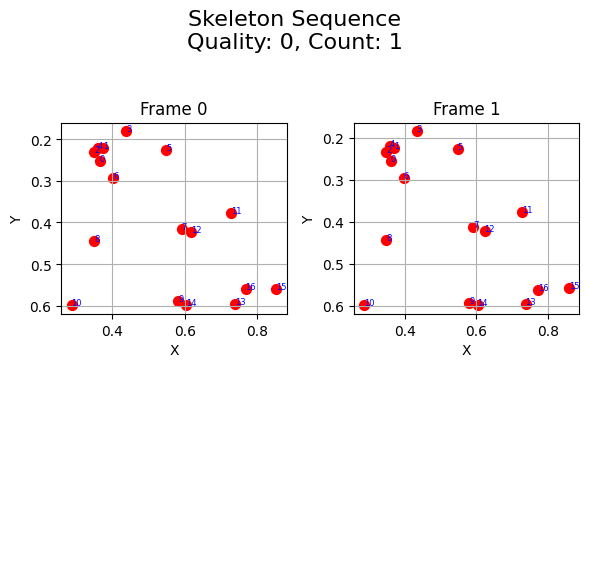


KeyboardInterrupt



In [5]:
import matplotlib.pyplot as plt

def visualize_skeleton_sequence(data_tensor, quality_label, count_label):
    """
    Функция для визуализации последовательности скелетных данных.
    
    Аргументы:
      data_tensor: тензор скелетных данных формы (seq_len, num_joints, 2)
      quality_label: метка качества (например, 0, 1, 2)
      count_label: метка сгибов (например, 0, 1 или иное целое число)
      
    Отображается последовательность кадров (например, 16 фреймов) в сетке 4x4.
    """
    # Если data_tensor – тензор Torch, переводим в numpy
    if isinstance(data_tensor, torch.Tensor):
        data_tensor = data_tensor.cpu().numpy()
    
    seq_len = data_tensor.shape[0]
    # Количество строк и столбцов в сетке (например, 4x4 для 16 кадров)
    nrows = int(np.ceil(np.sqrt(seq_len)))
    ncols = nrows

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
    axs = axs.flatten()  # превращаем в одномерный список для удобства

    for i in range(seq_len):
        frame = data_tensor[i]  # (num_joints, 2)
        ax = axs[i]
        ax.scatter(frame[:, 0], frame[:, 1], c='red', s=50)
        # Добавляем номера суставов для наглядности
        for j, (x, y) in enumerate(frame):
            ax.text(x, y, f"{j}", fontsize=6, color="blue")
        ax.set_title(f"Frame {i}")
        ax.invert_yaxis()  # если нужно инвертировать ось Y
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.grid(True)

    # Если осталось лишние subplots, скрываем их:
    for i in range(seq_len, len(axs)):
        axs[i].axis('off')

    plt.suptitle(f"Skeleton Sequence\nQuality: {quality_label}, Count: {count_label}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
for i in range(0,100):
    data_tensor, quality_label, count_label = val_dataset[i]
    visualize_skeleton_sequence(data_tensor, quality_label, count_label)


Validation samples: 5763


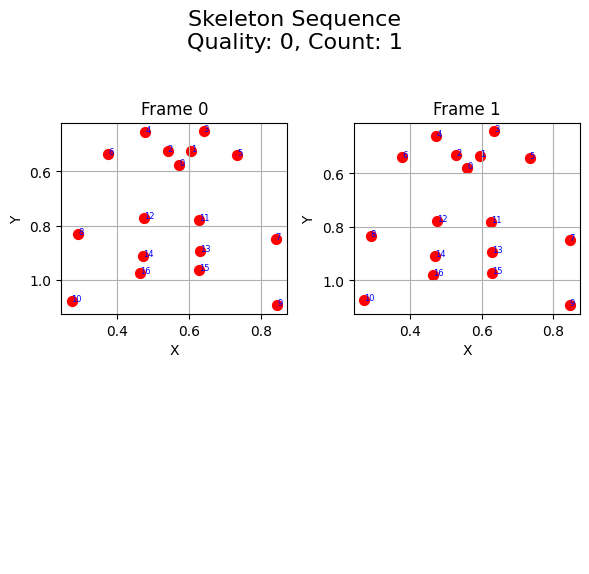

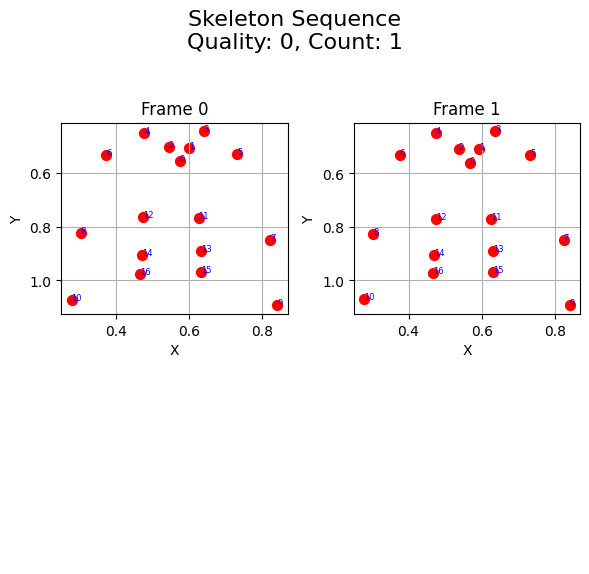

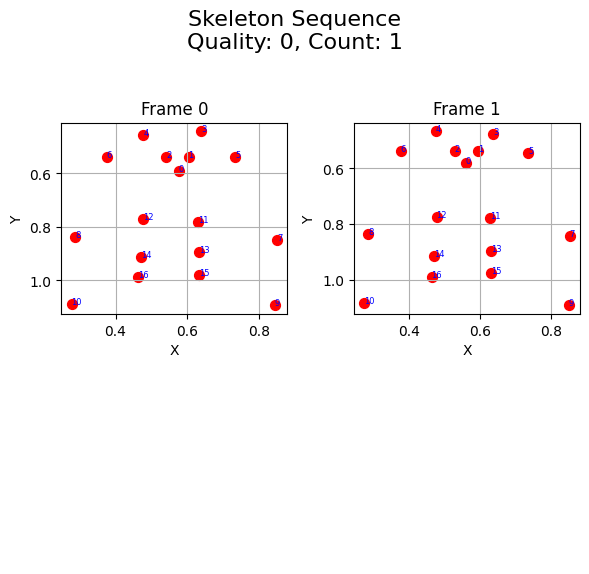

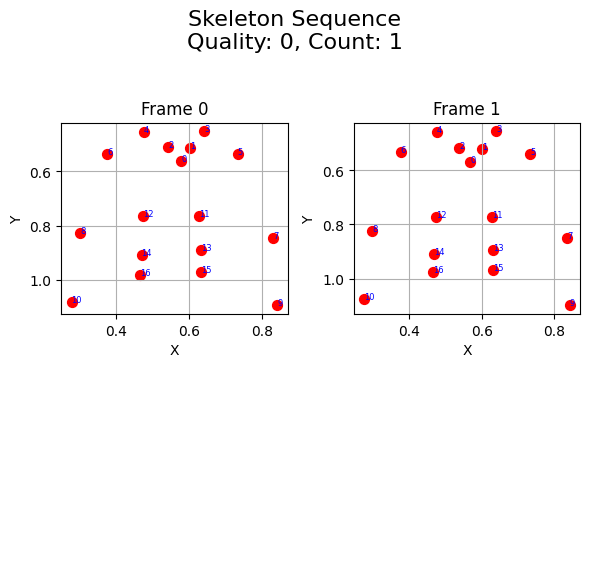

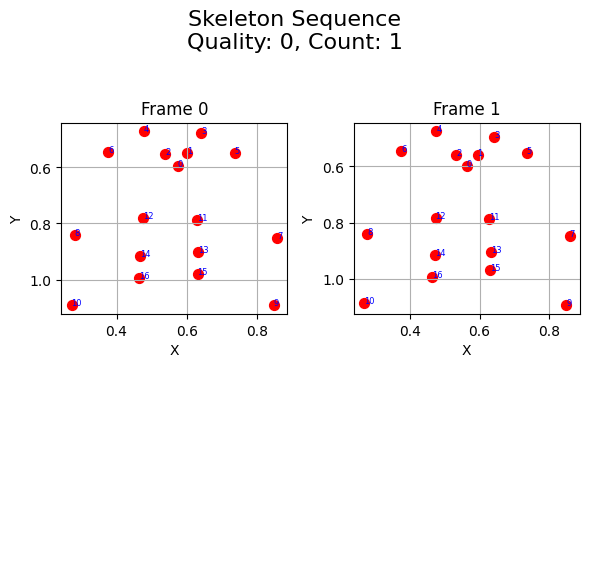

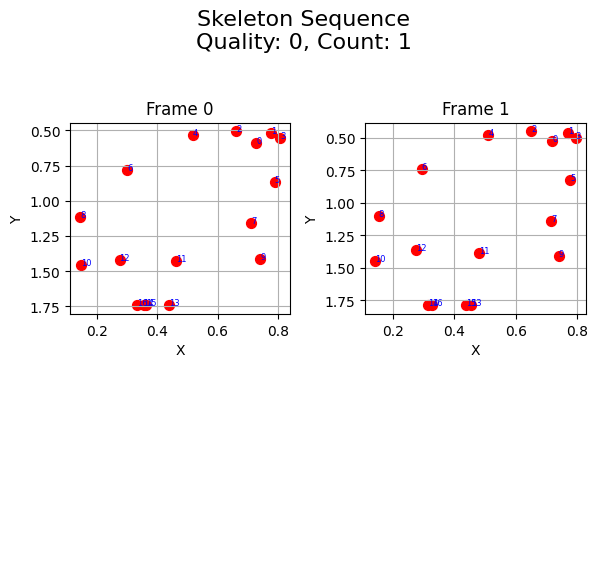

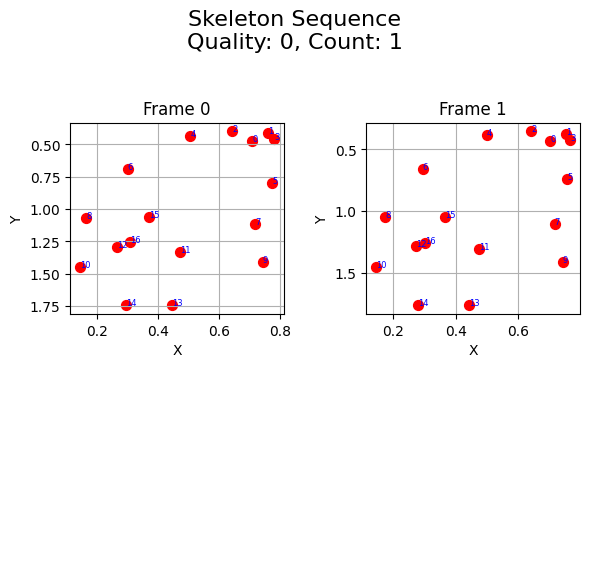

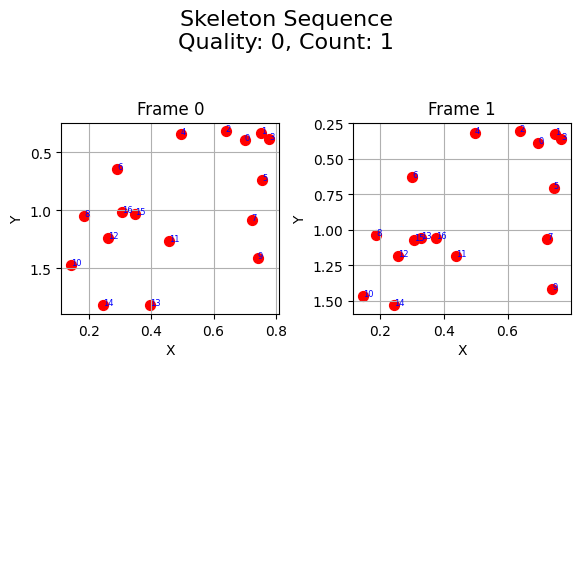

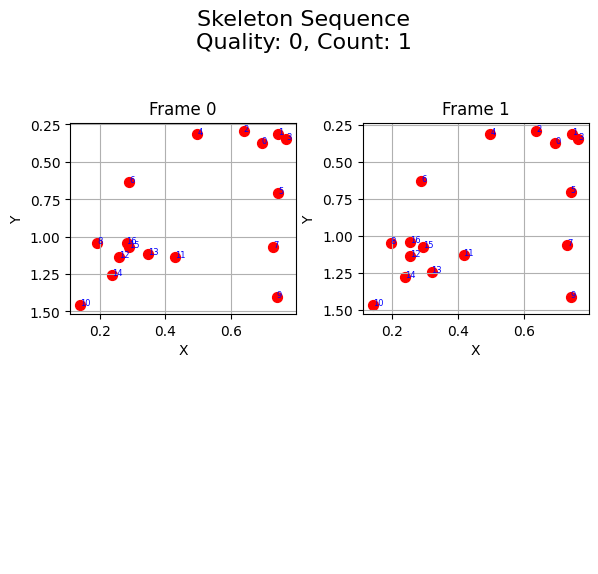

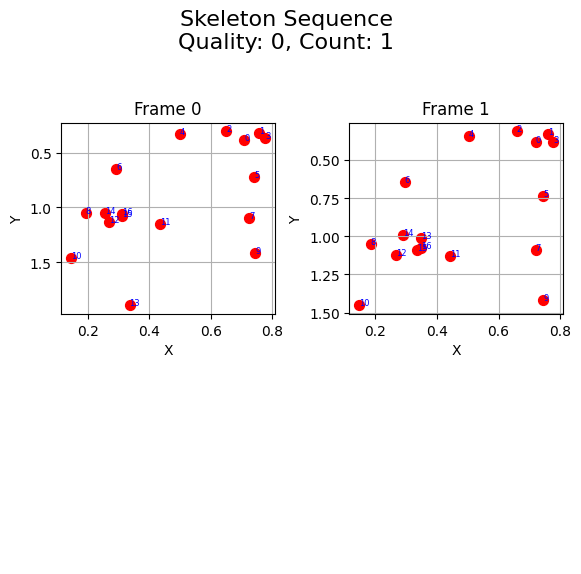

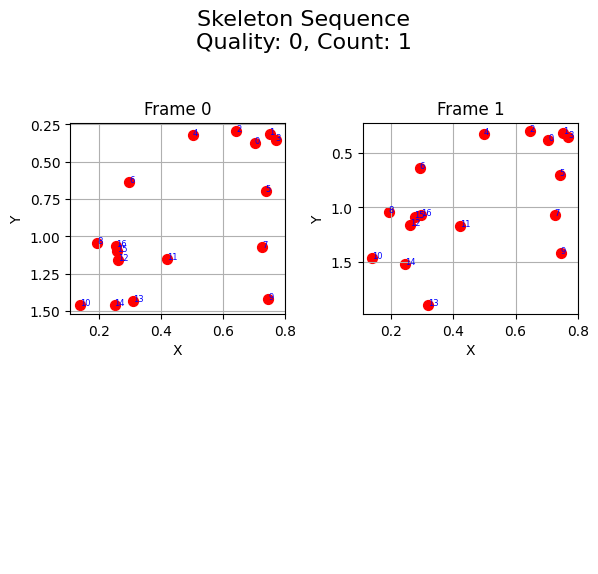

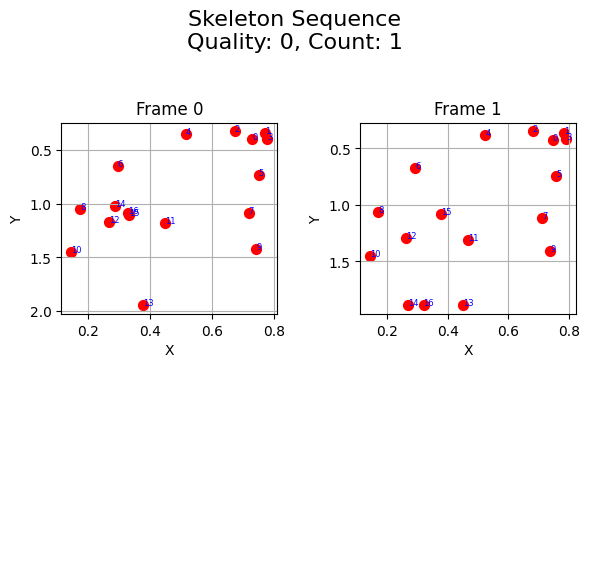

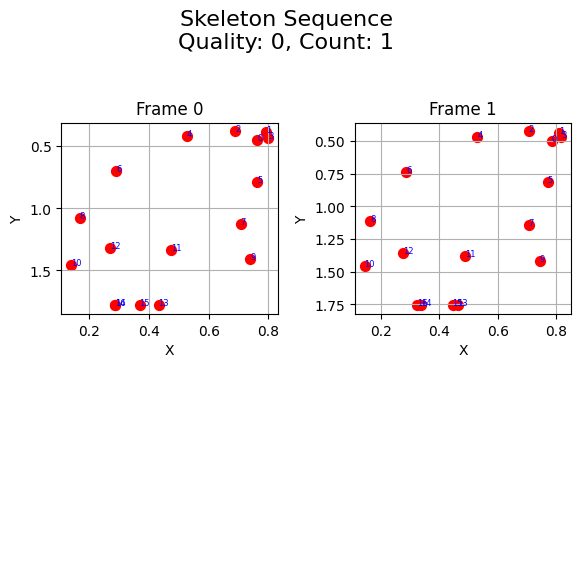

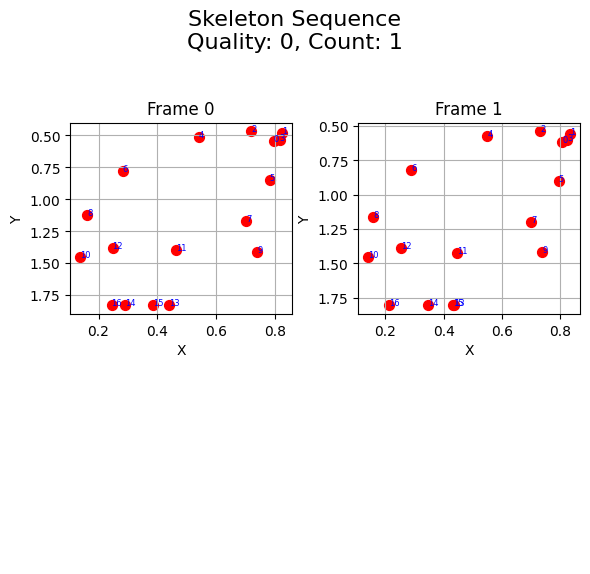

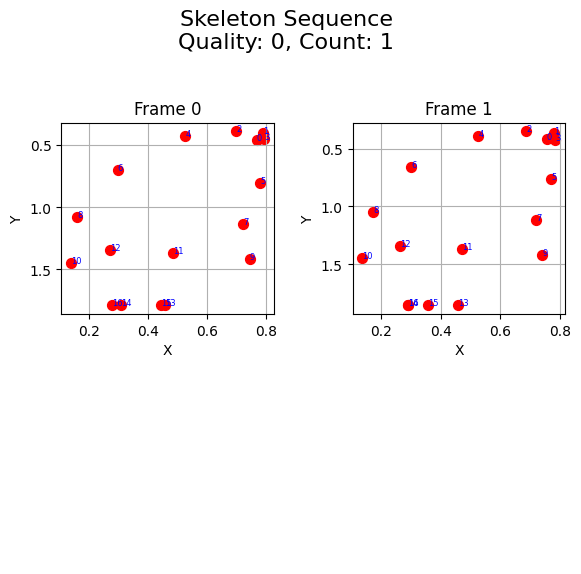

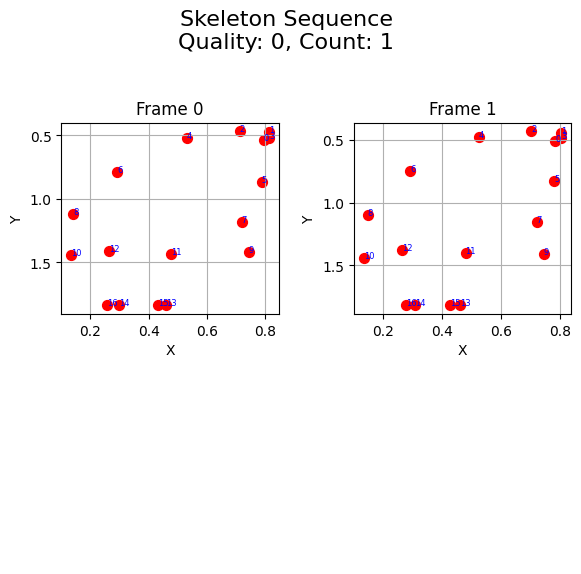

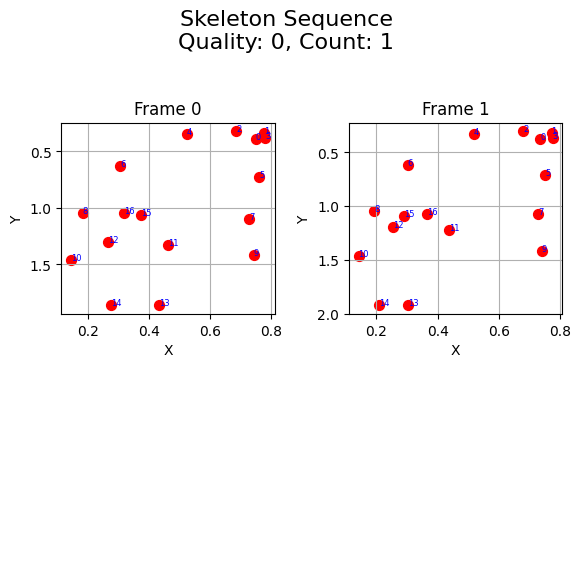

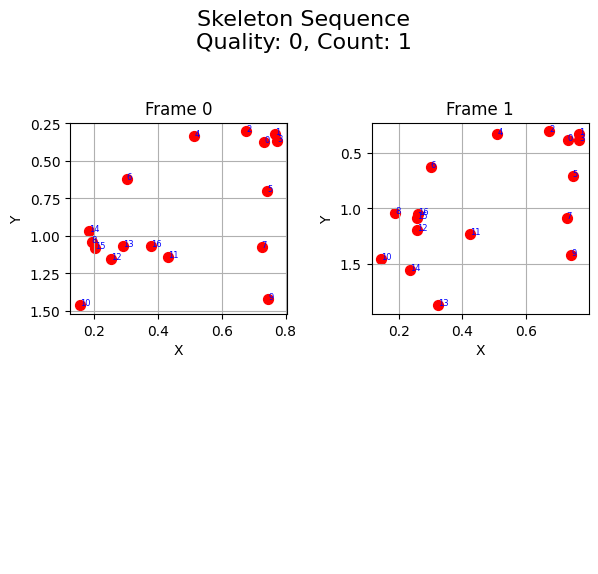

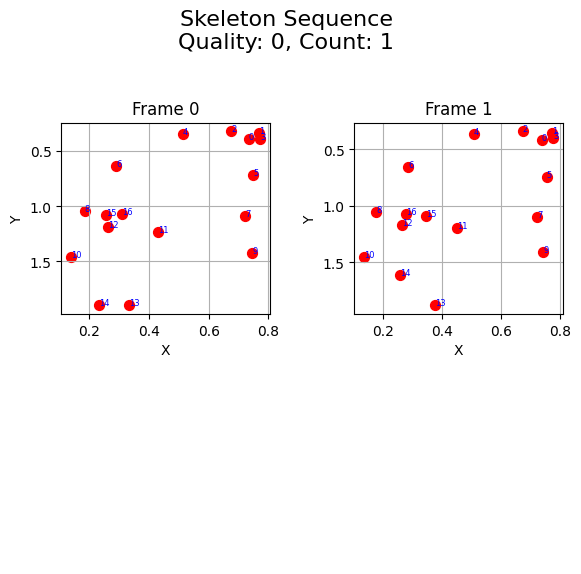

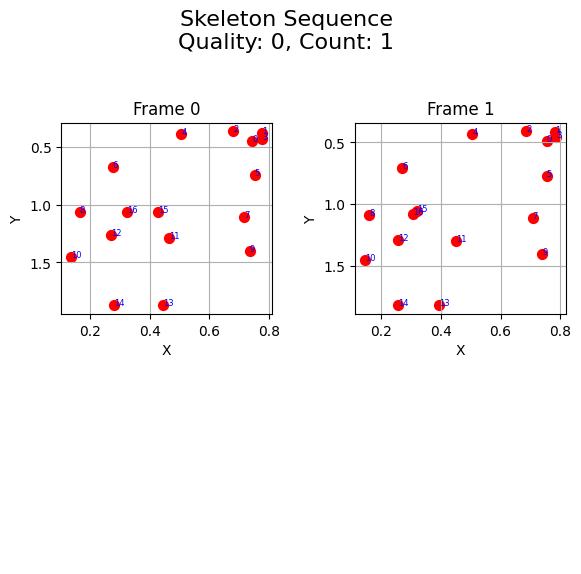

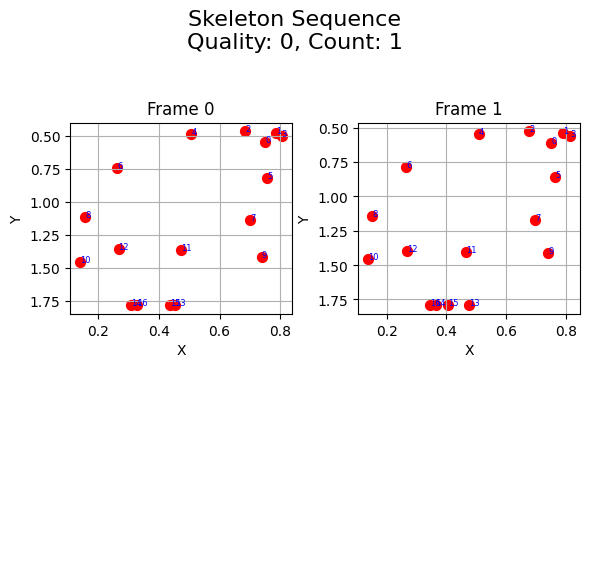

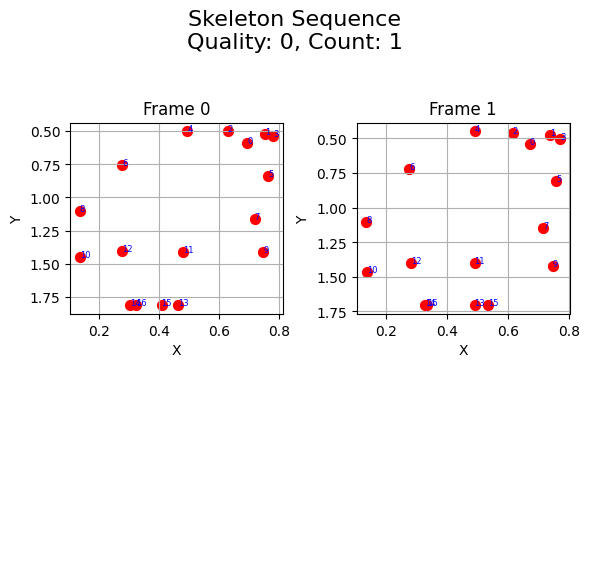

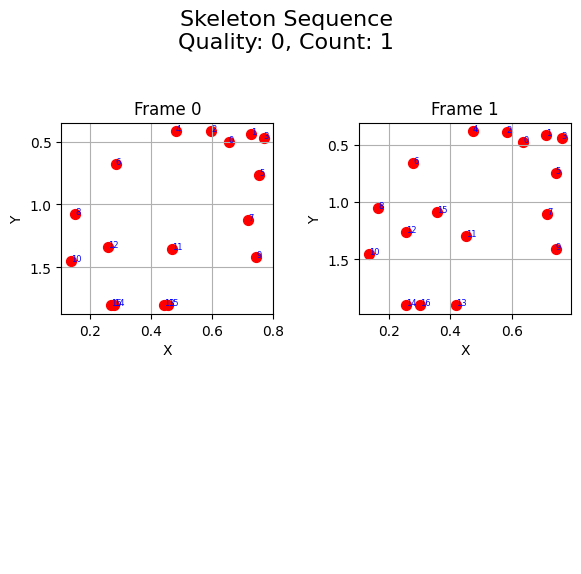

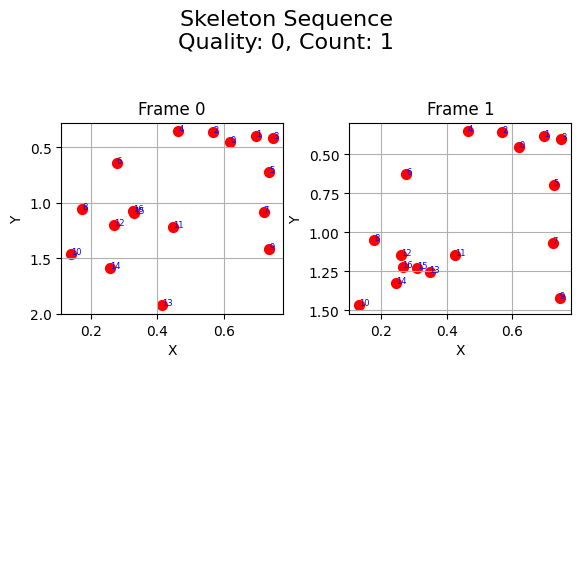

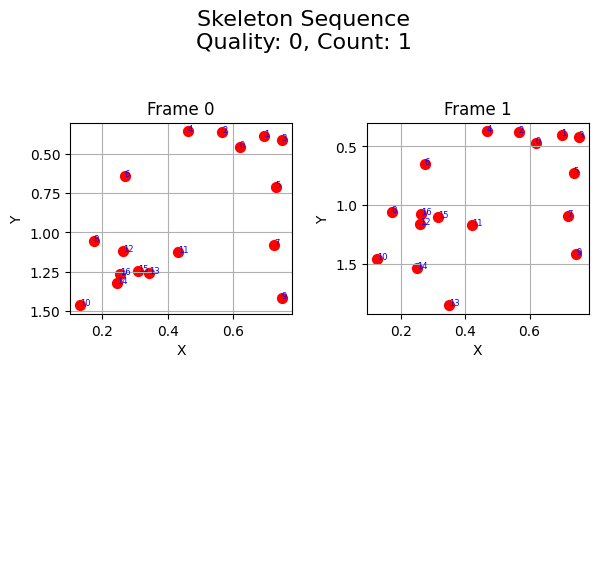

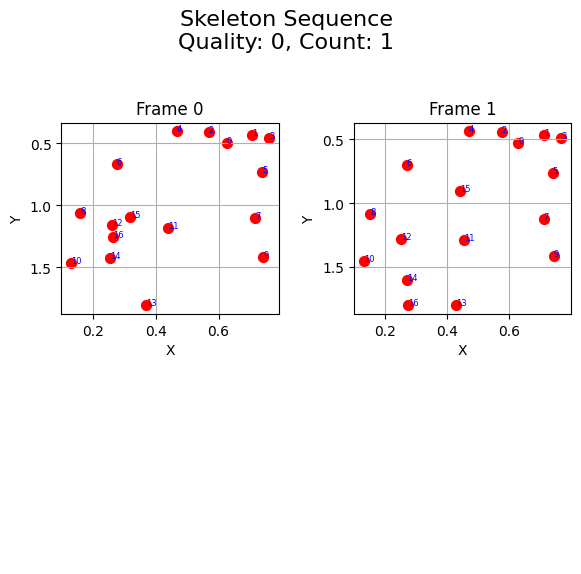

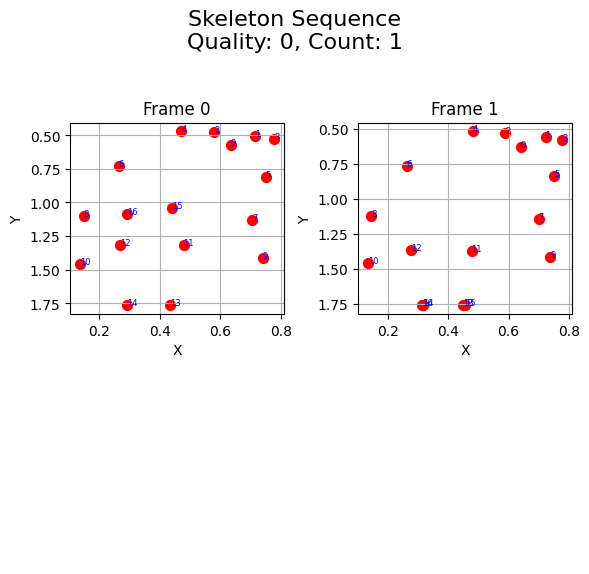

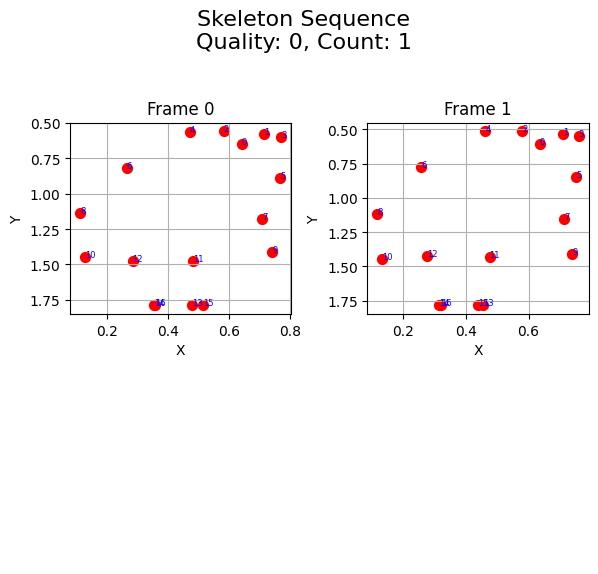

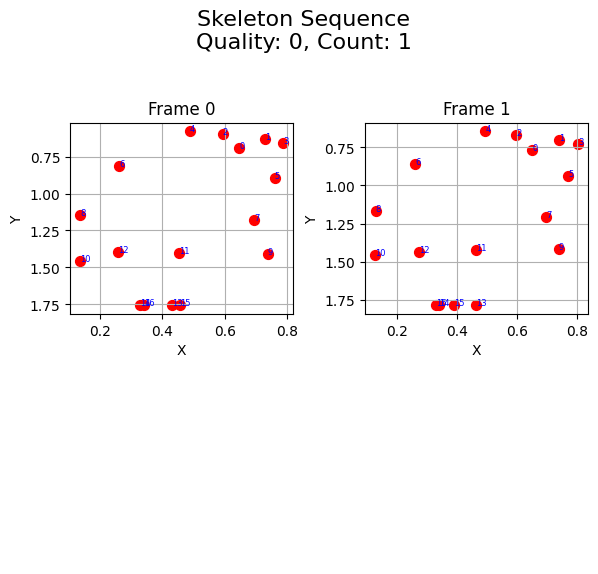

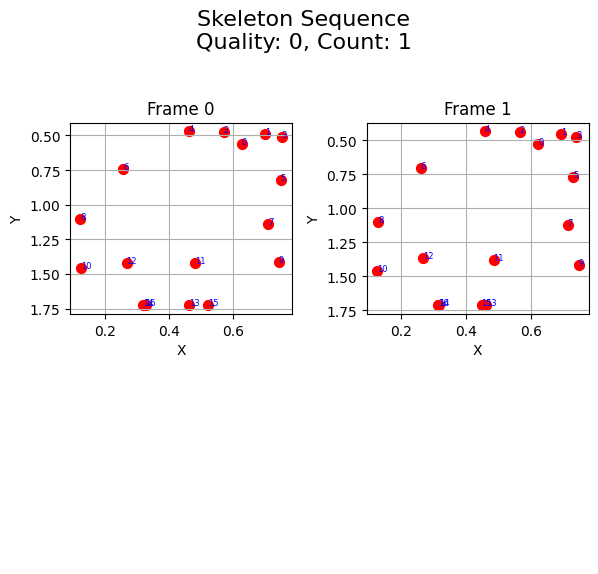

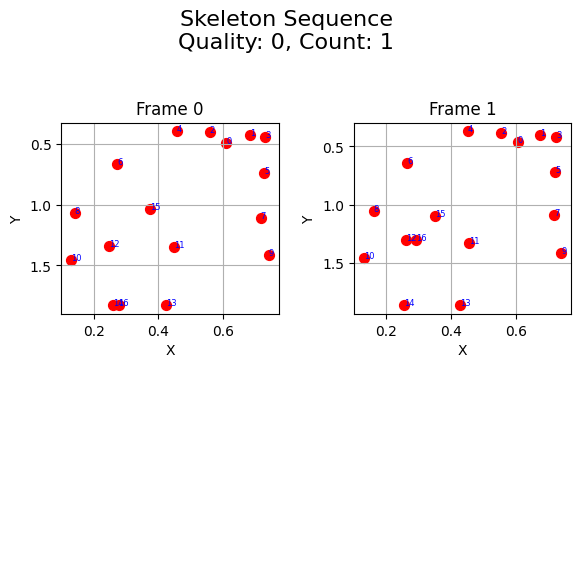

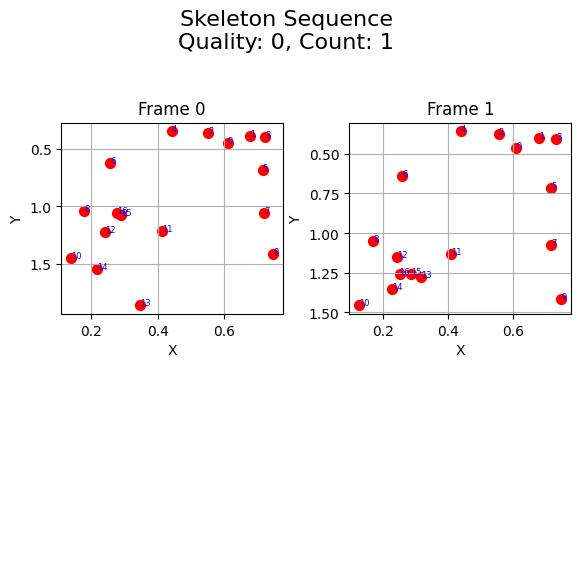

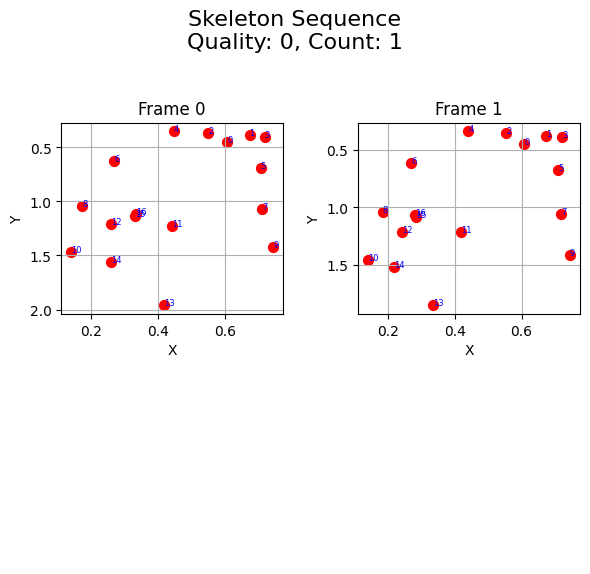

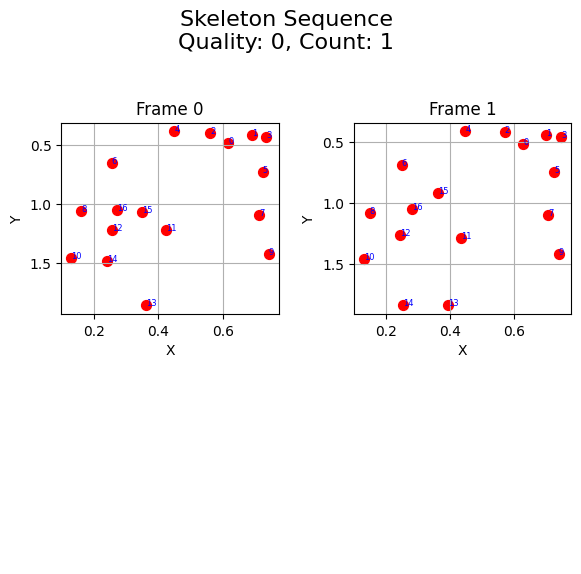

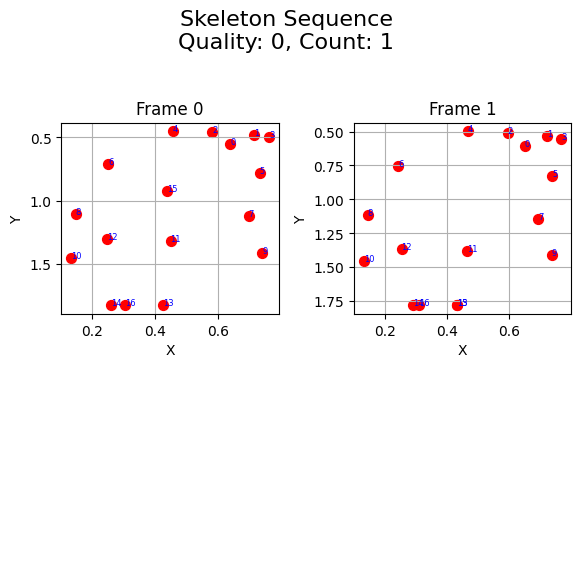

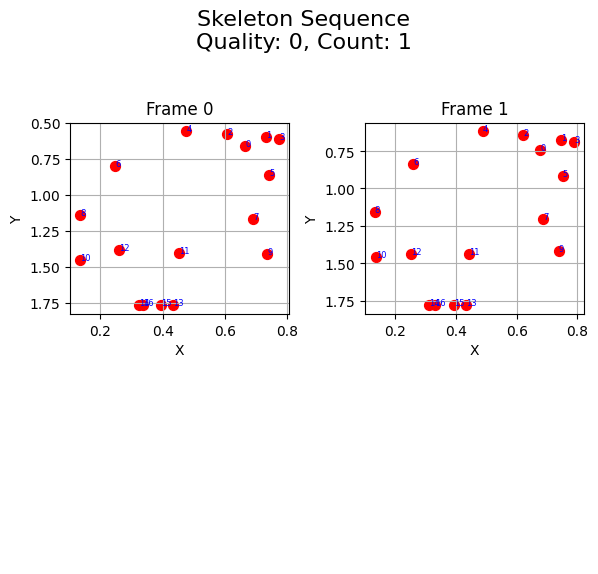

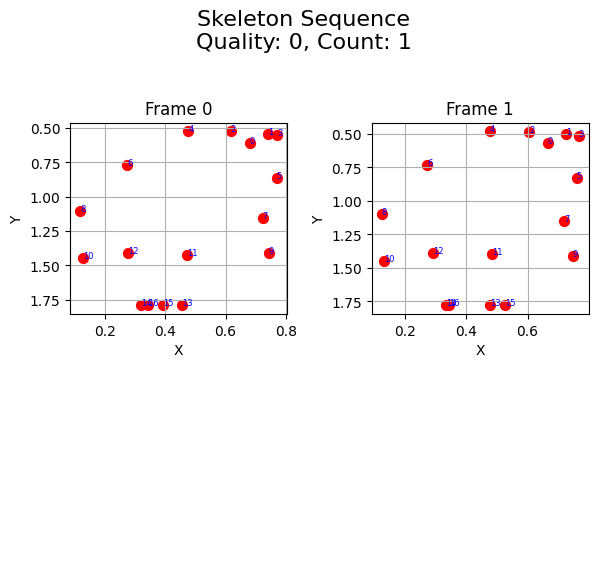

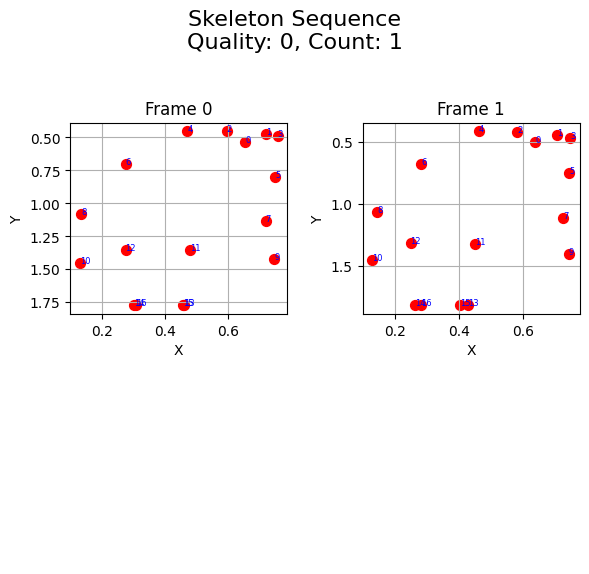

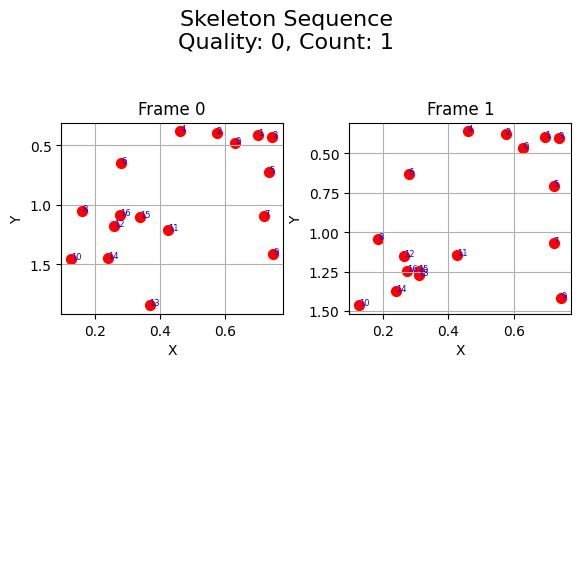

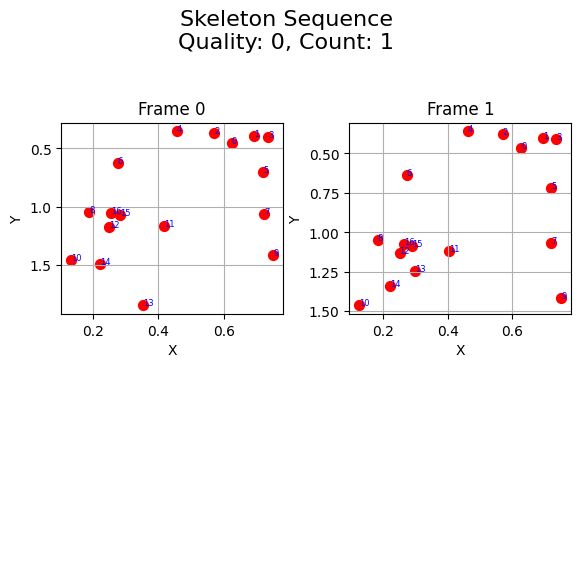

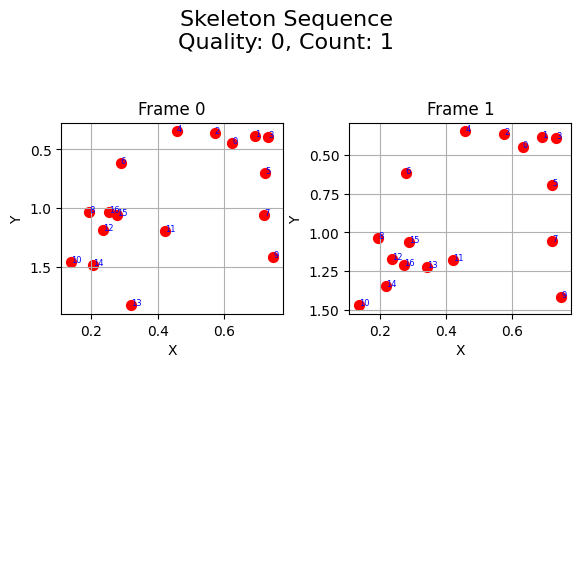

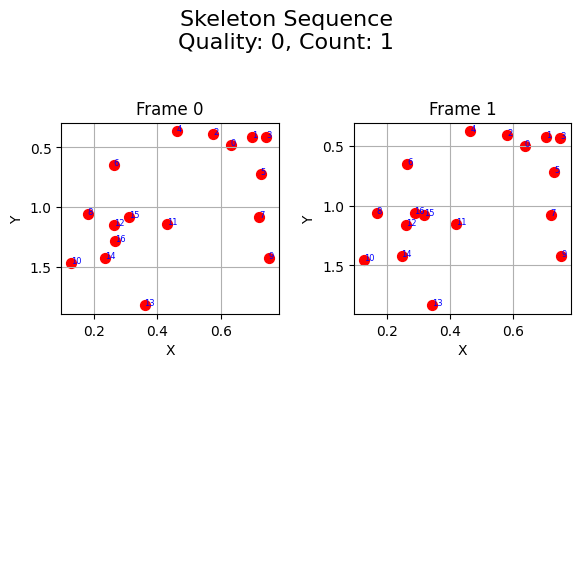

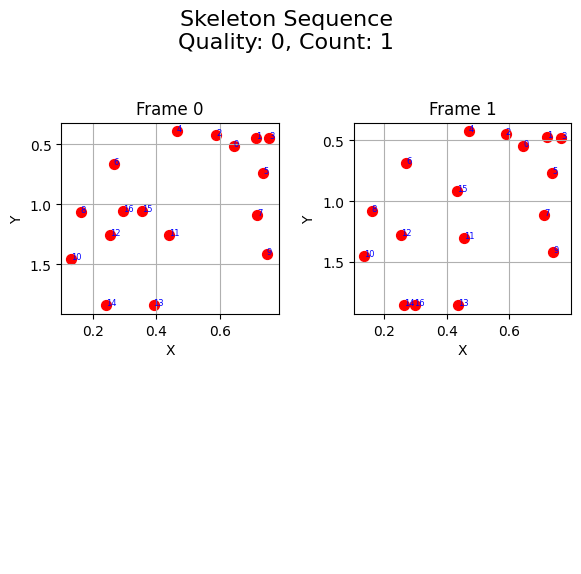

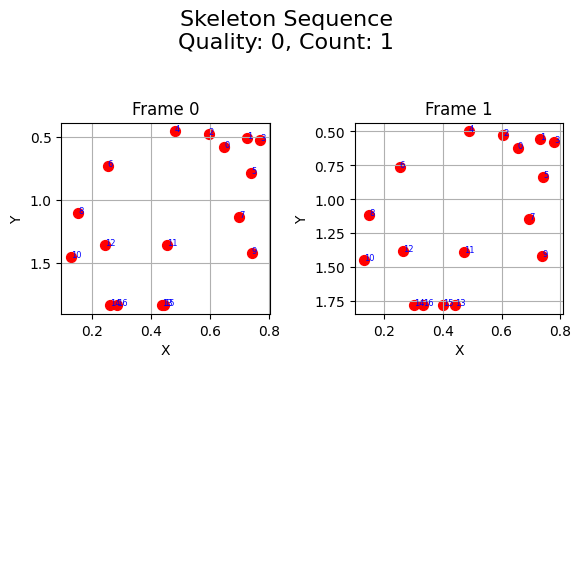

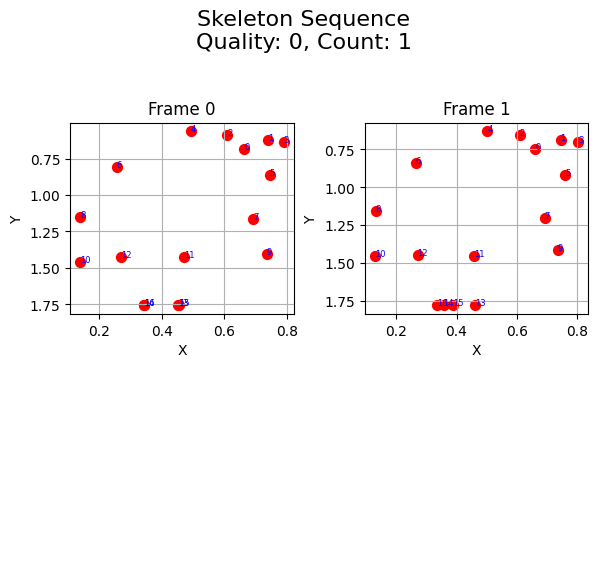

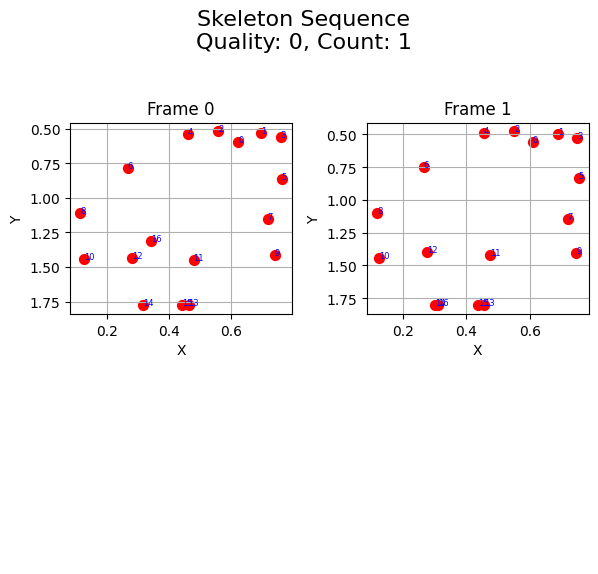

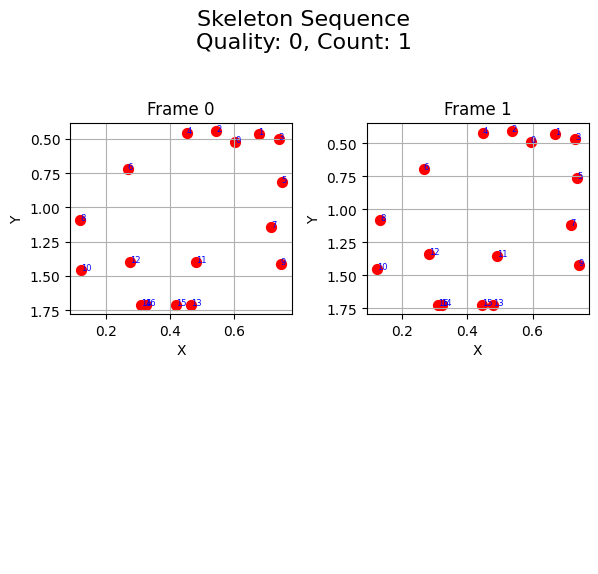

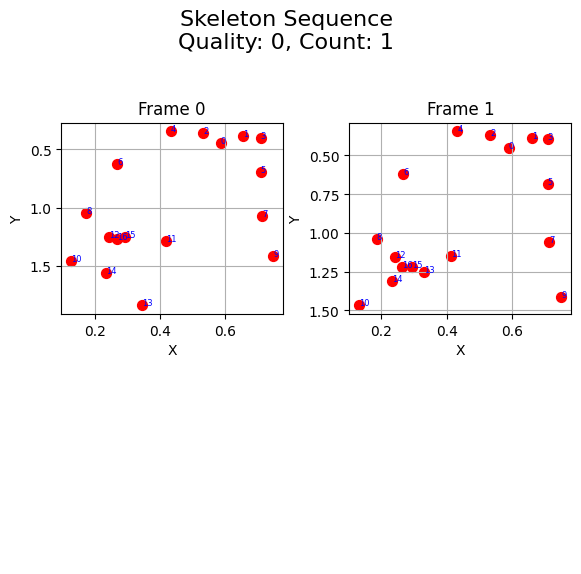

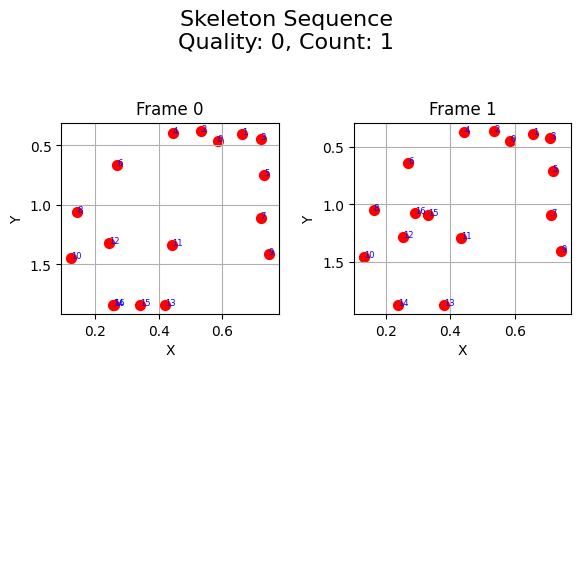

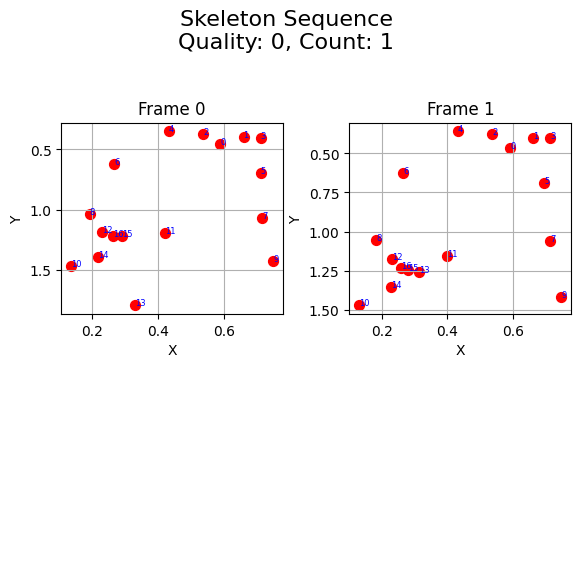

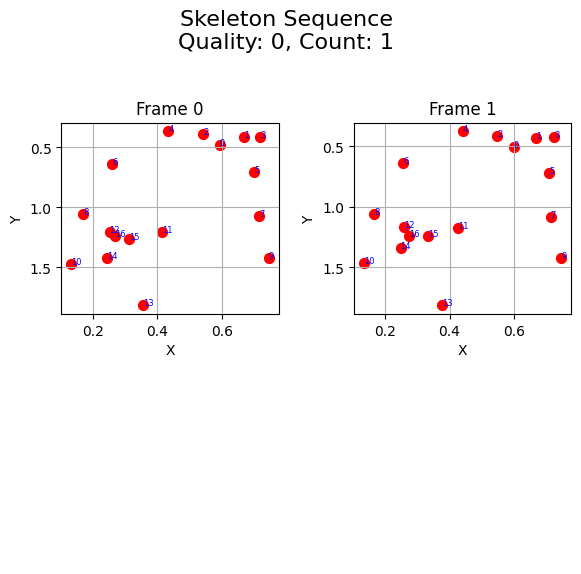

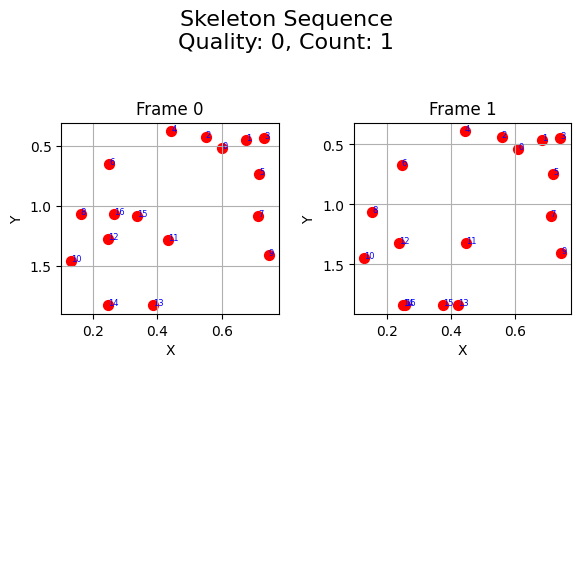

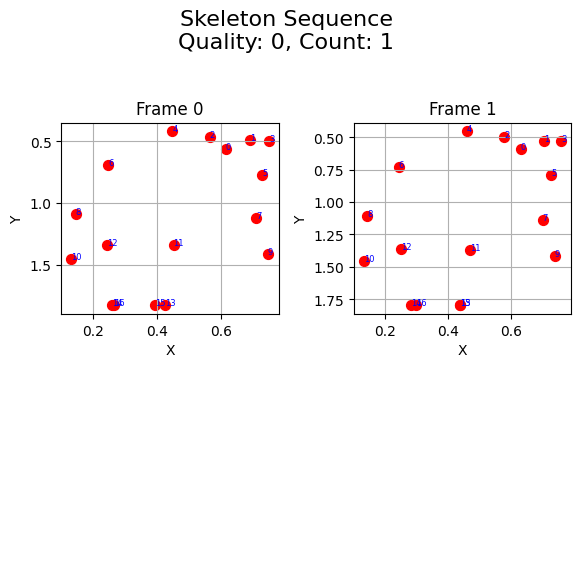

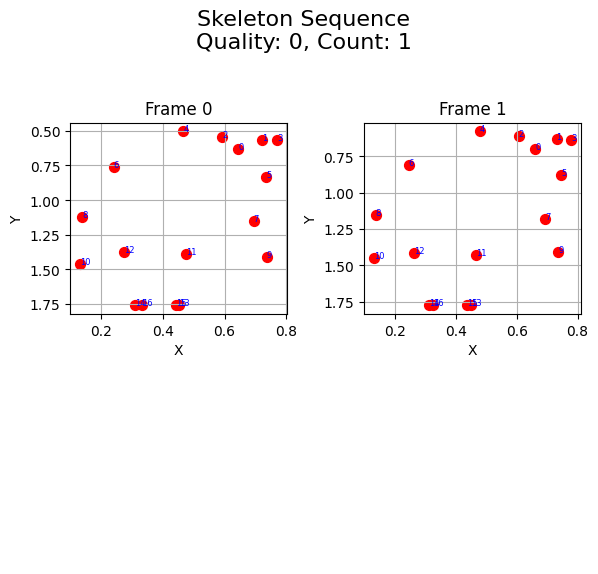

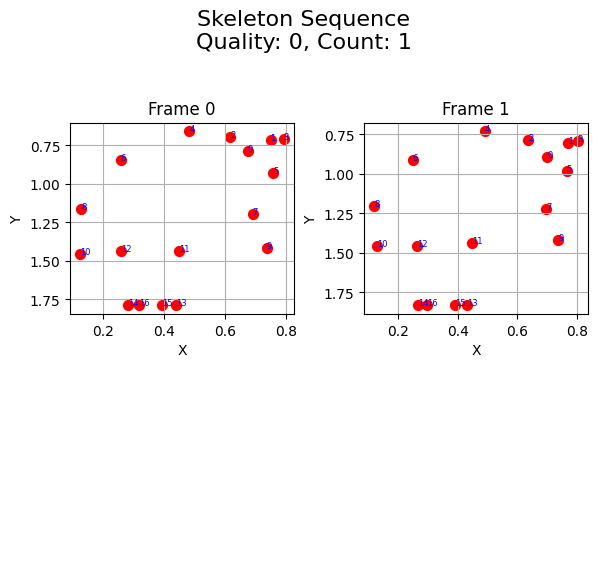

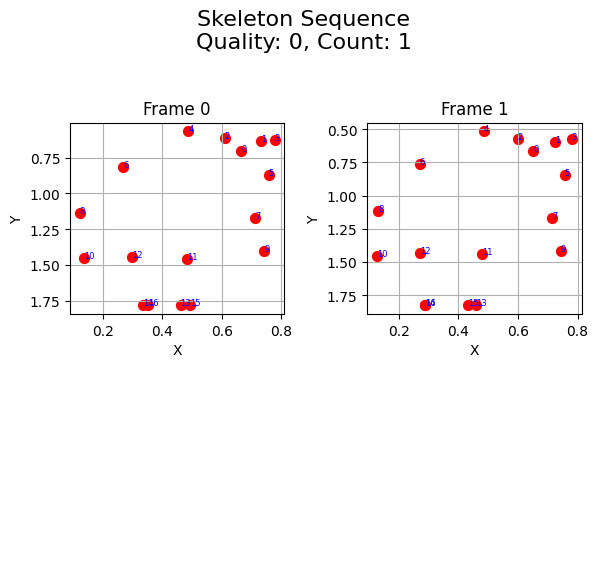

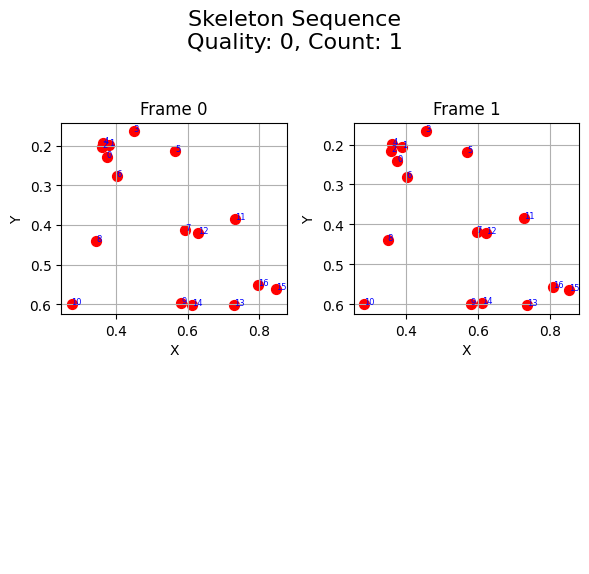

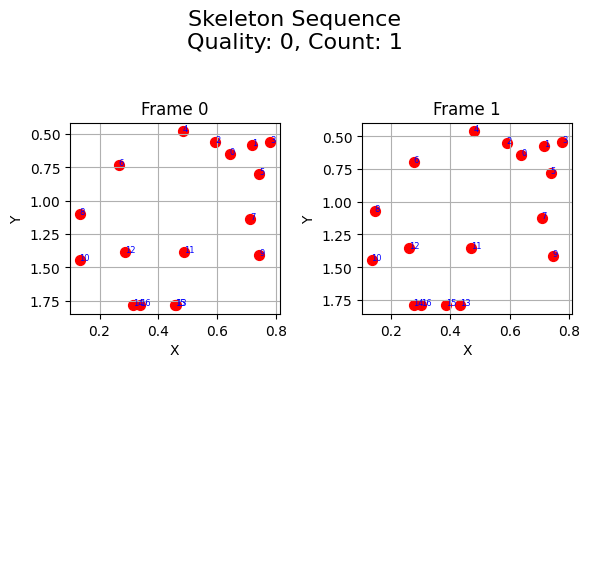

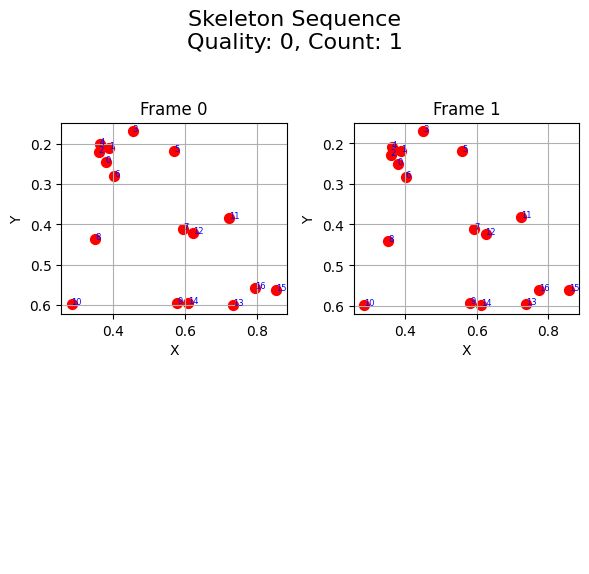

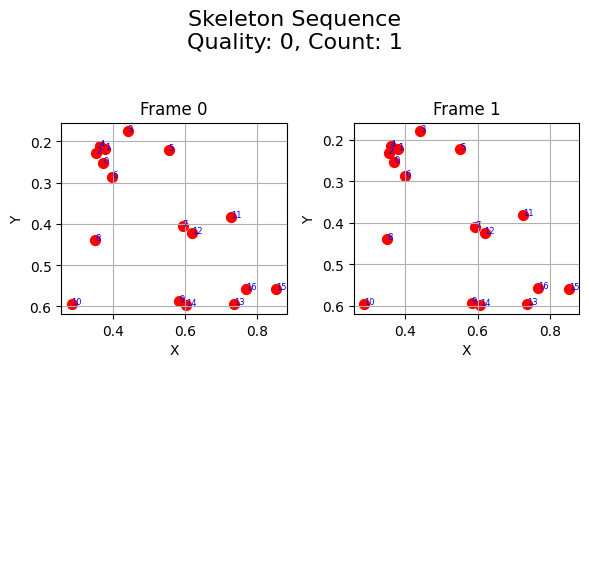

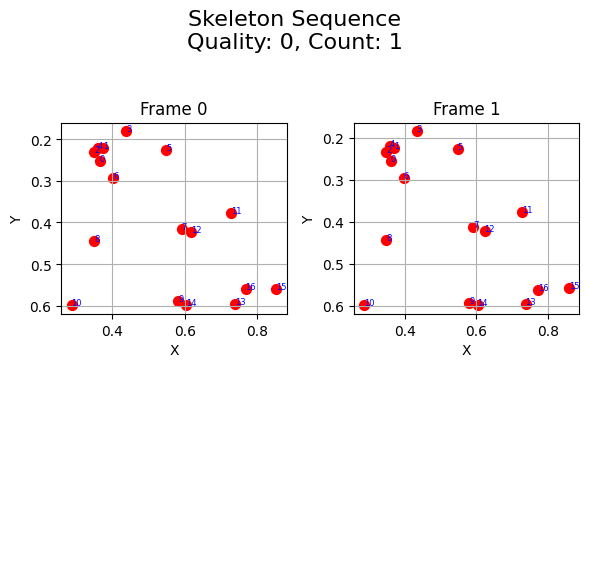

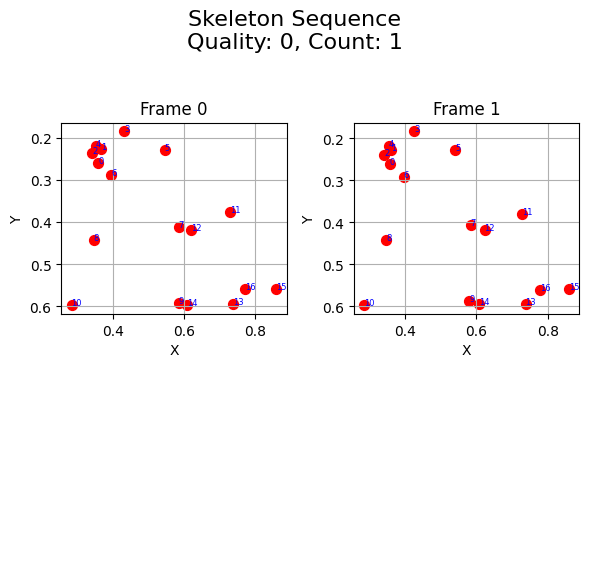

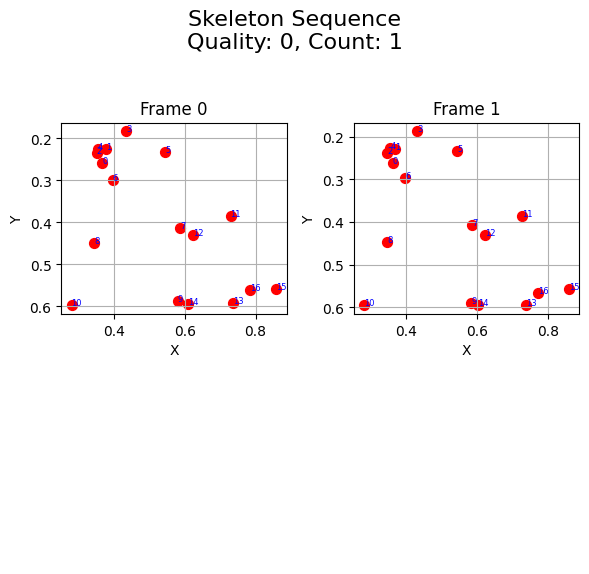

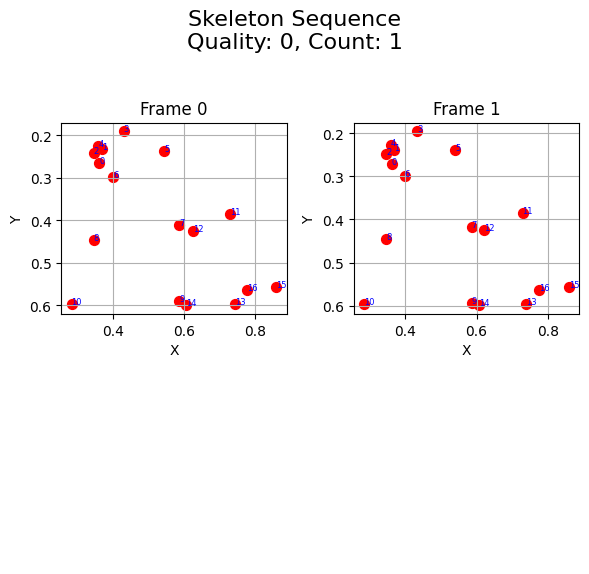

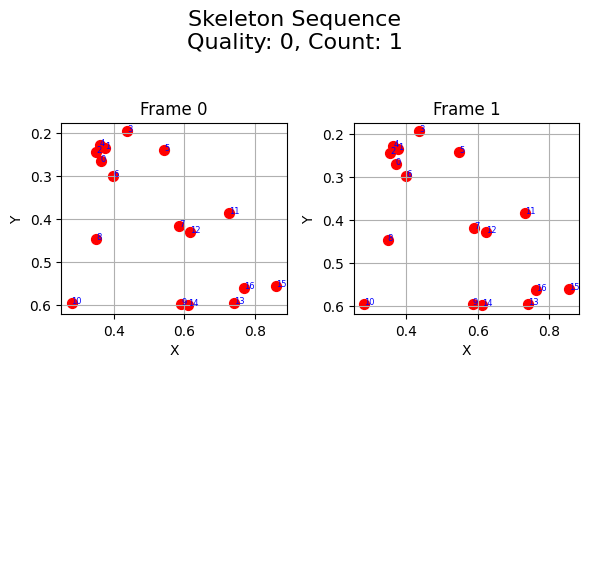

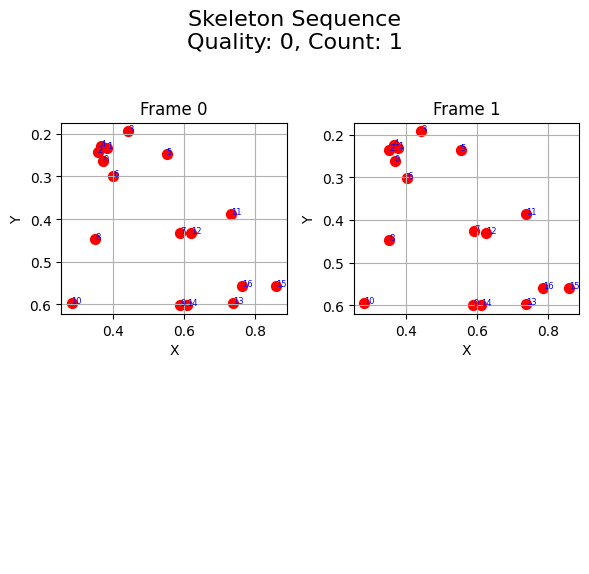

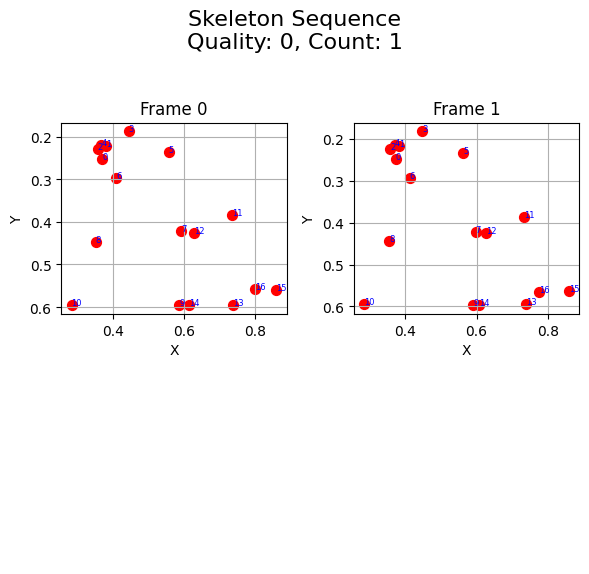

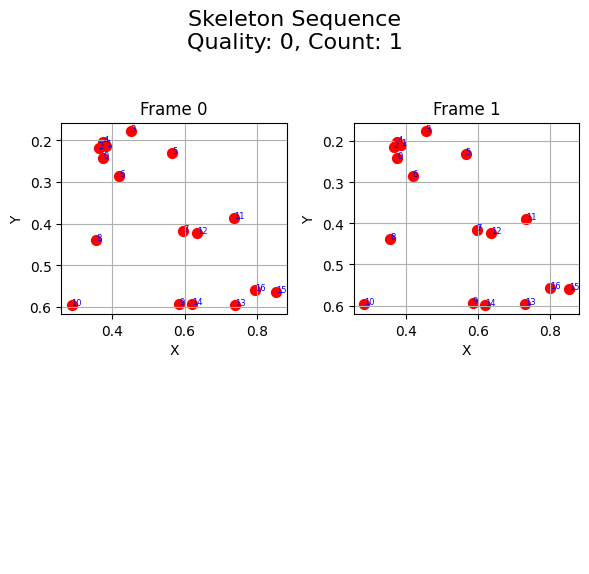

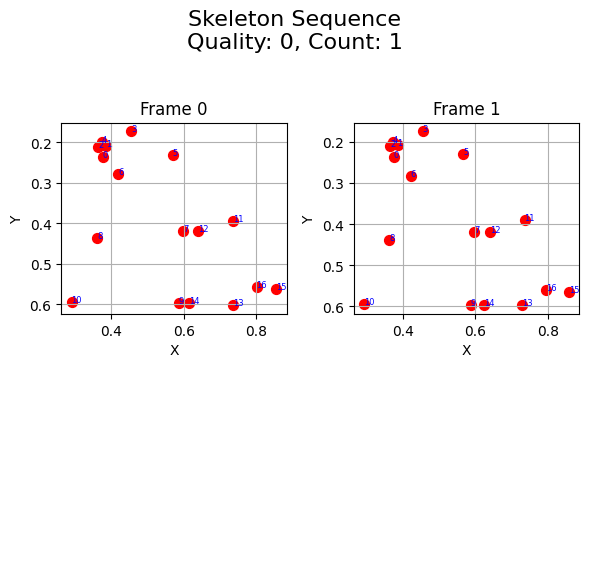

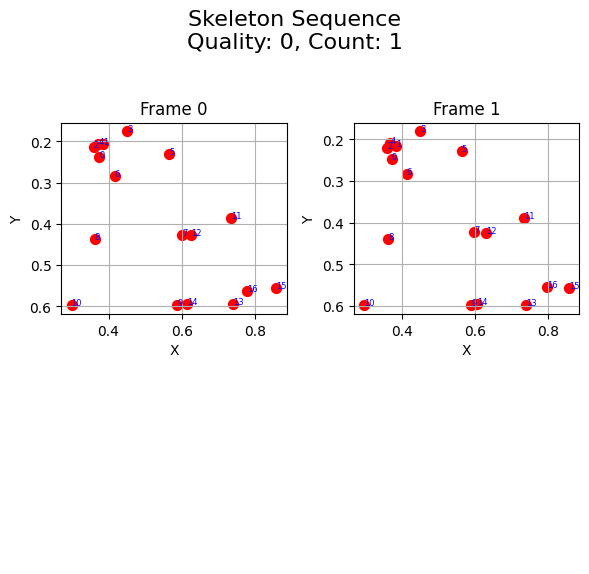

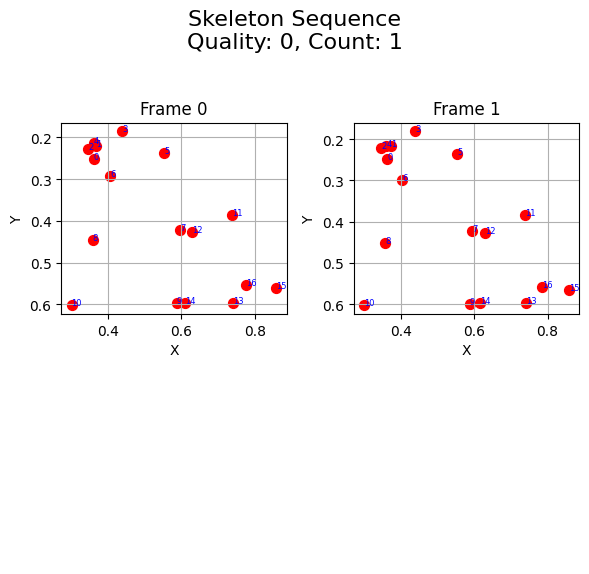

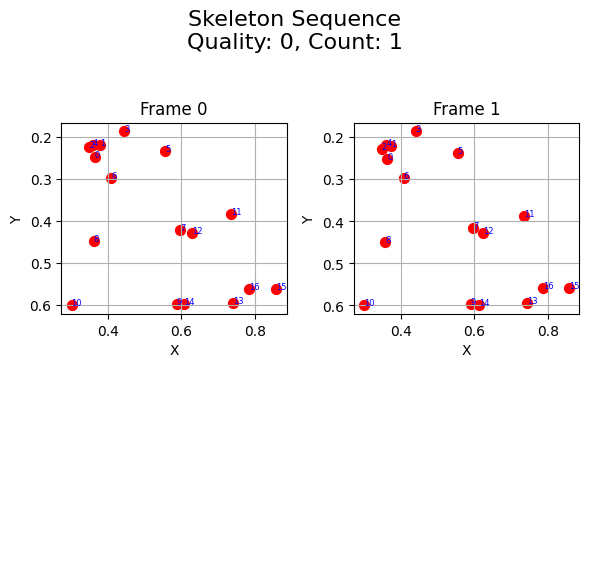

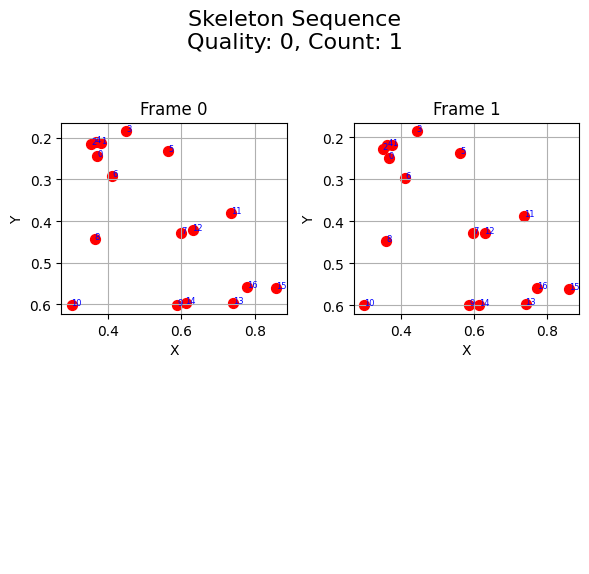

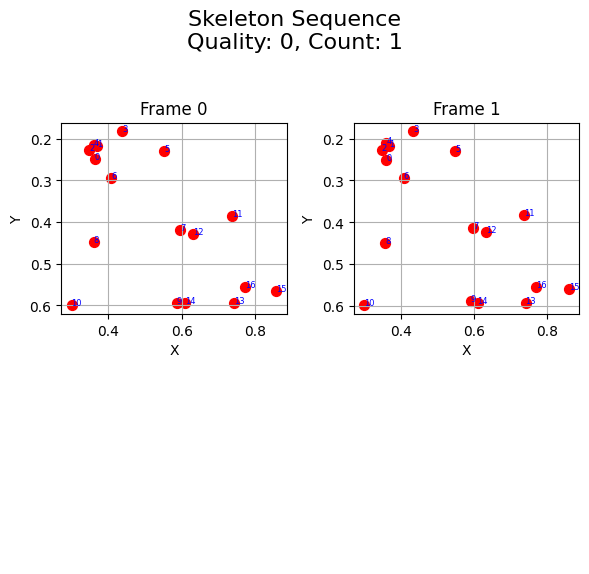

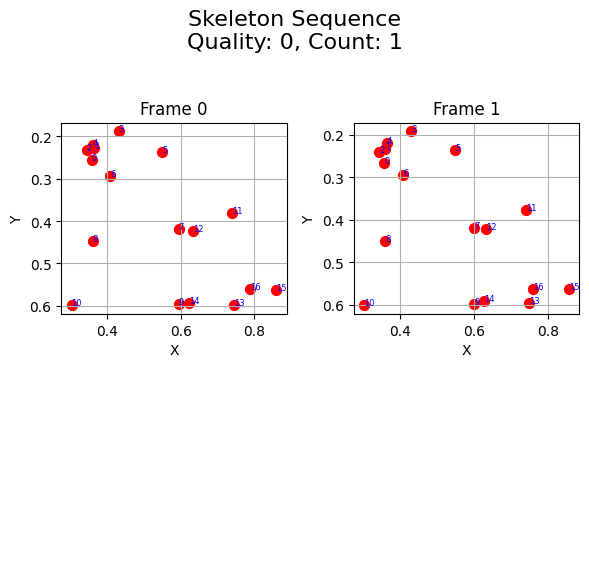

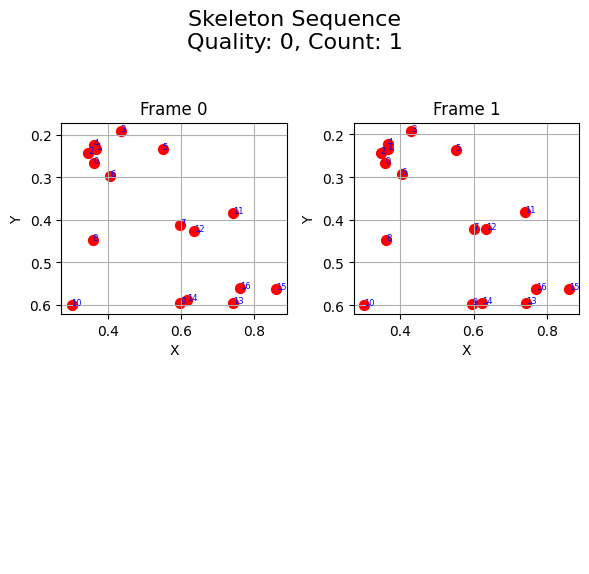

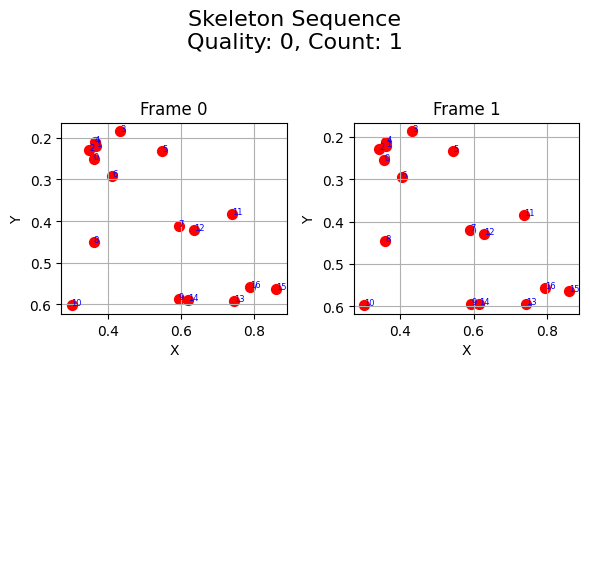

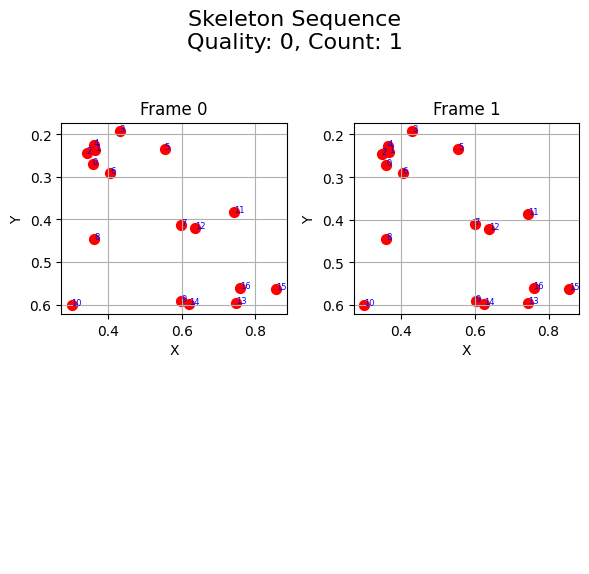

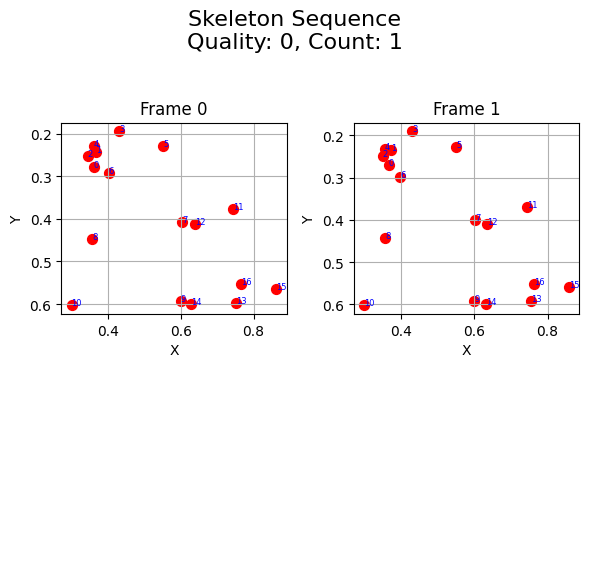

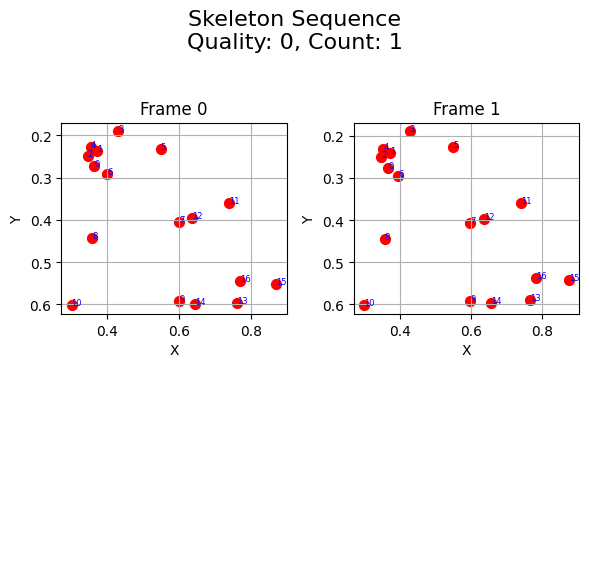

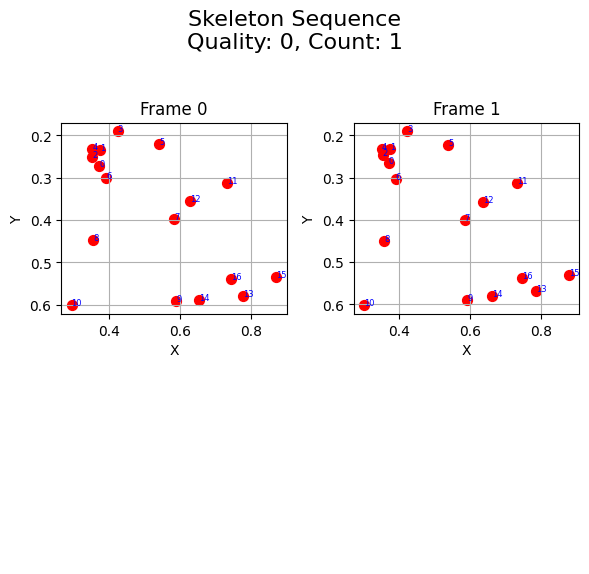

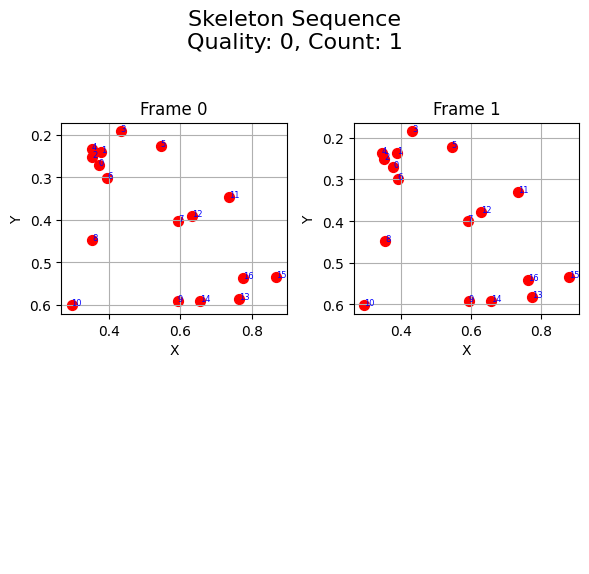

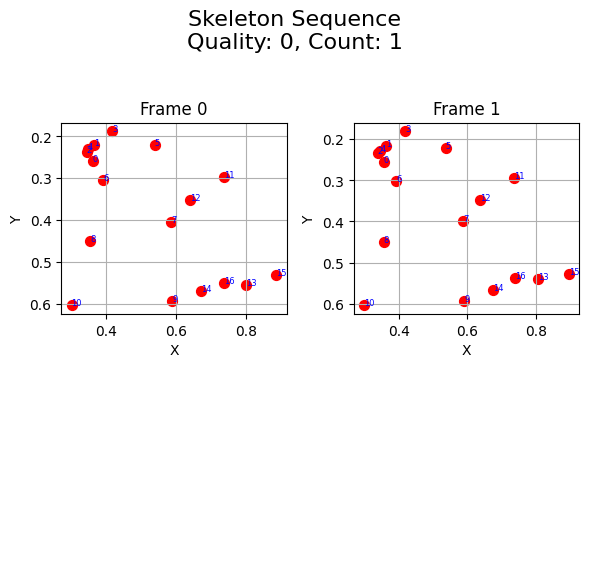

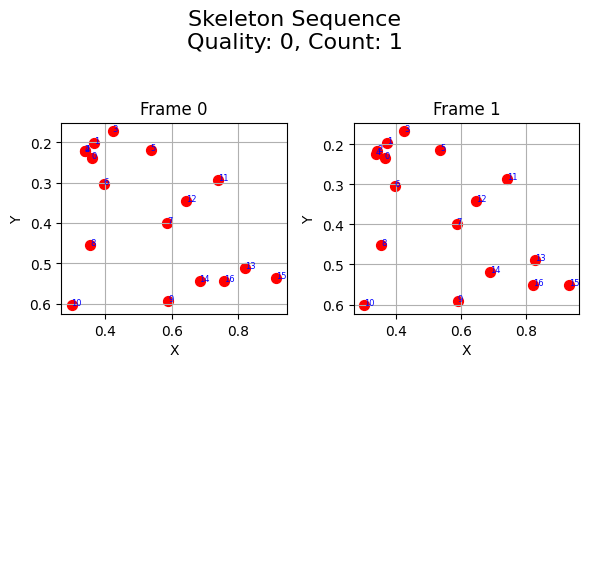

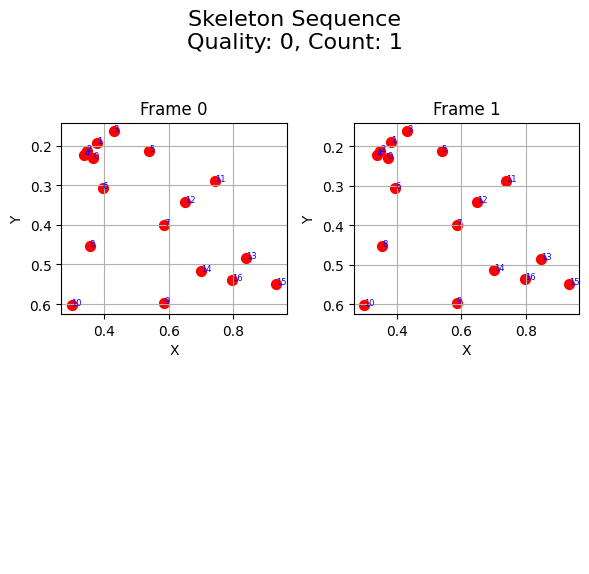

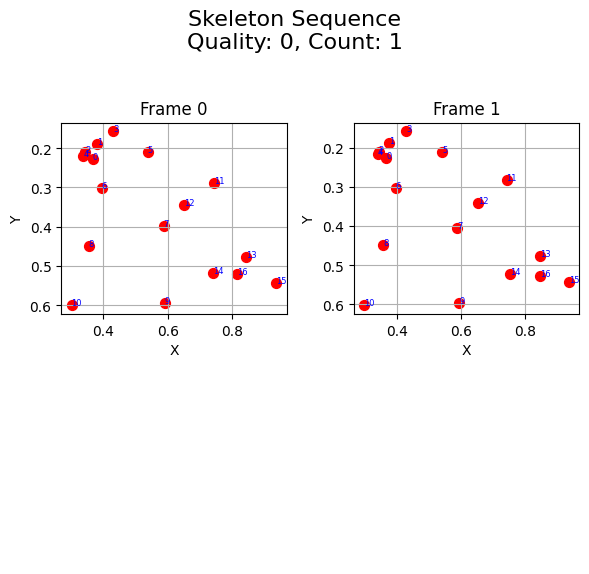

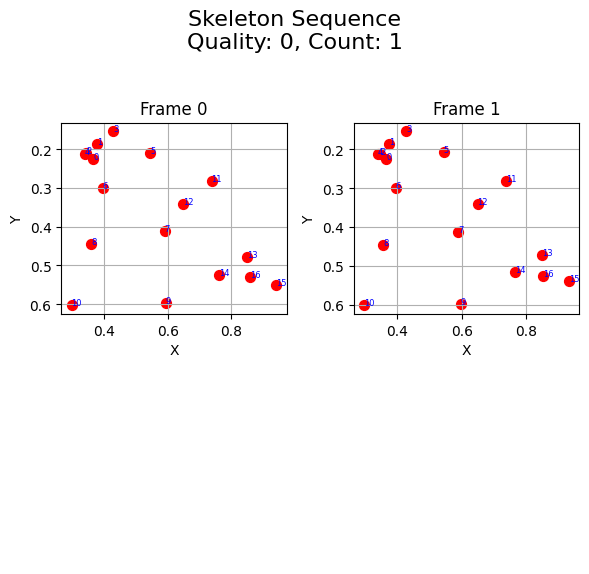

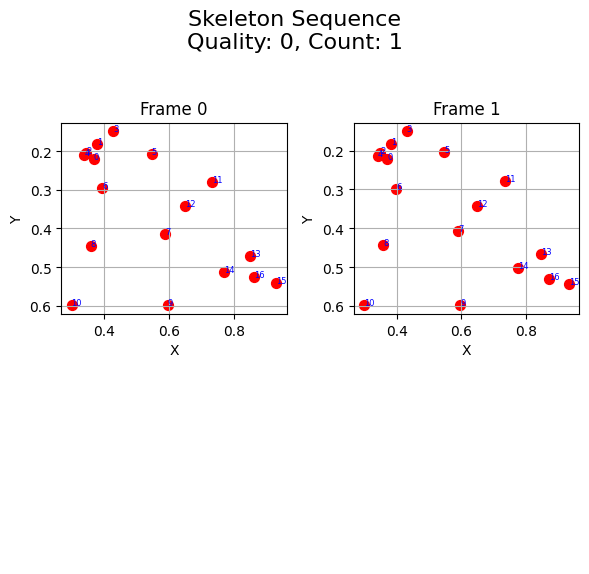

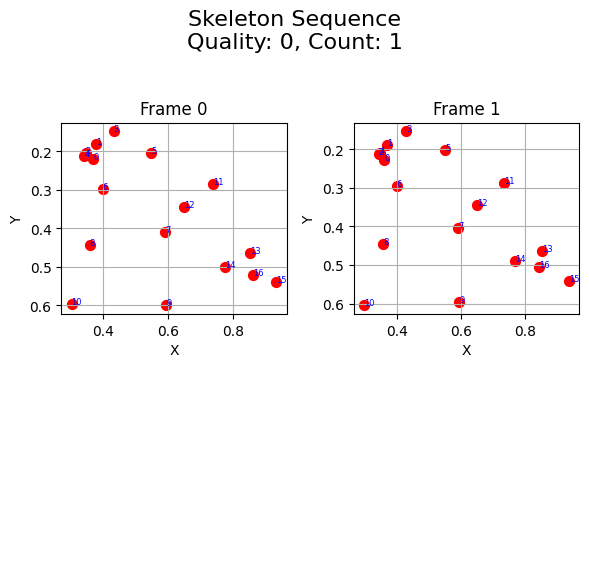

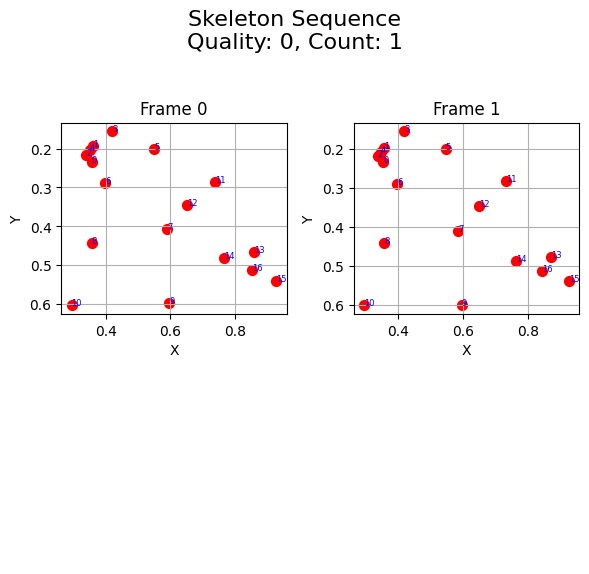

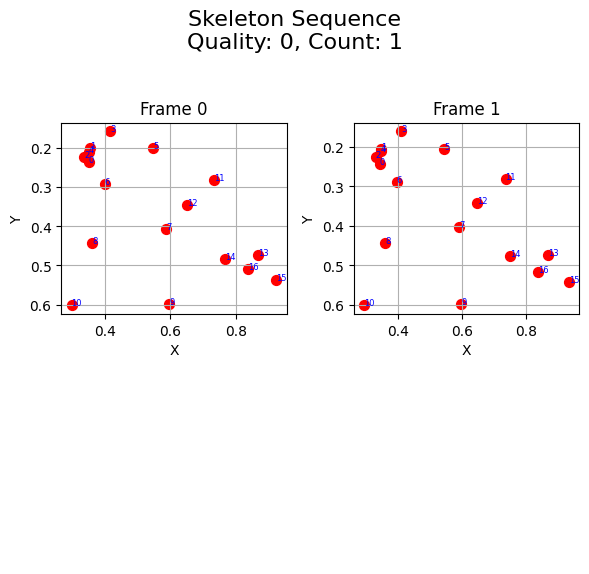

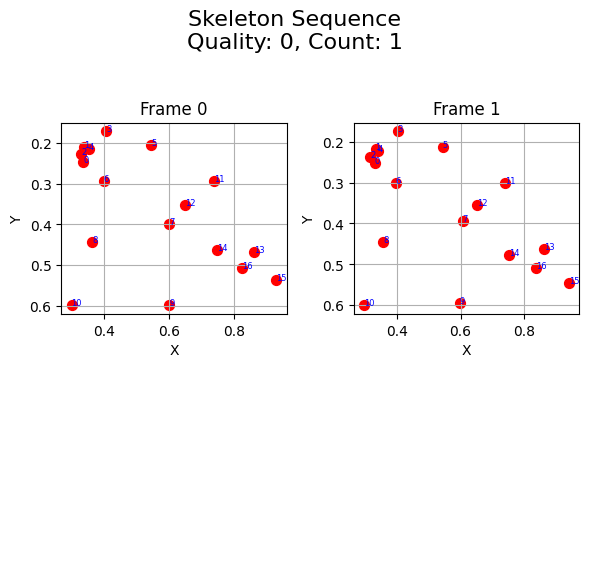

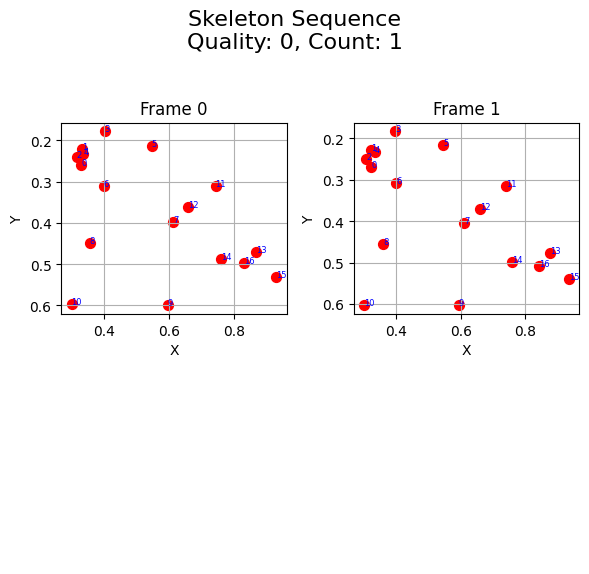

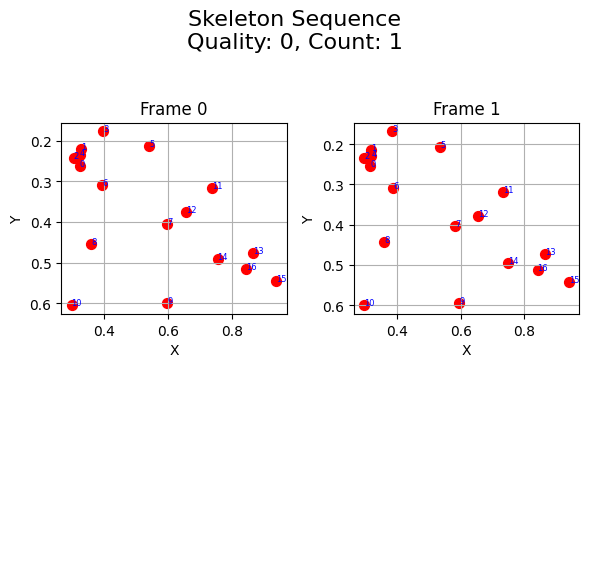

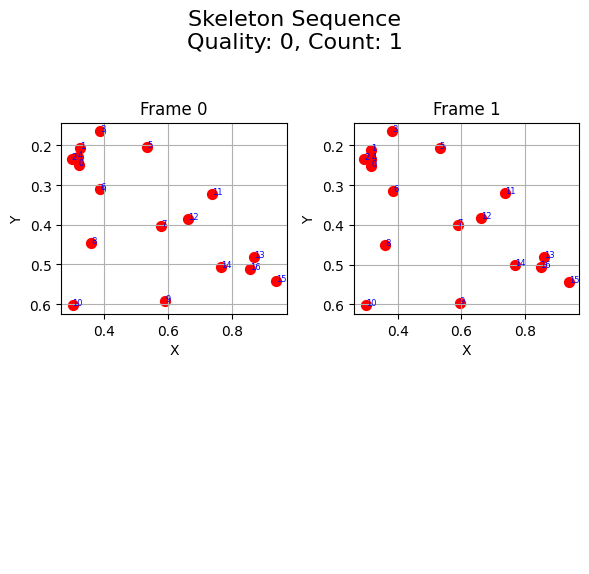

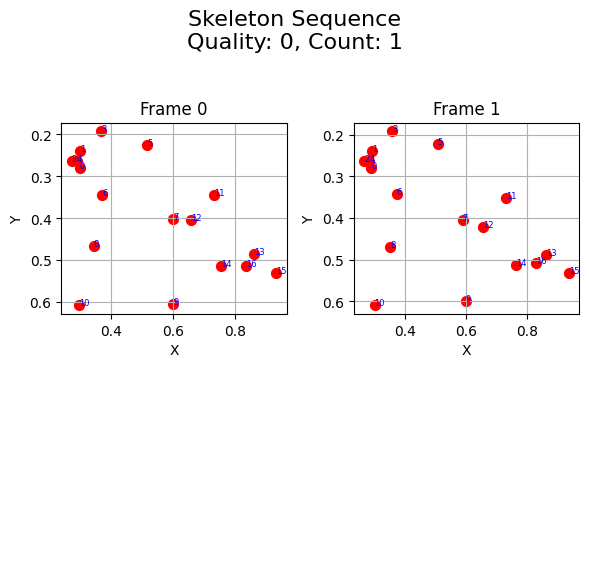

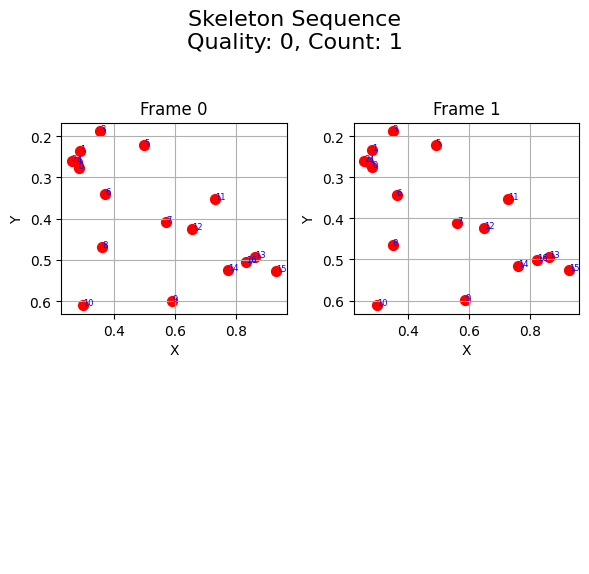

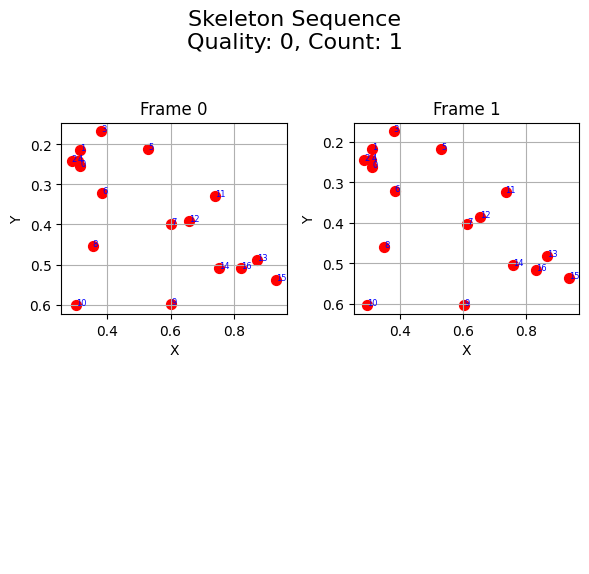

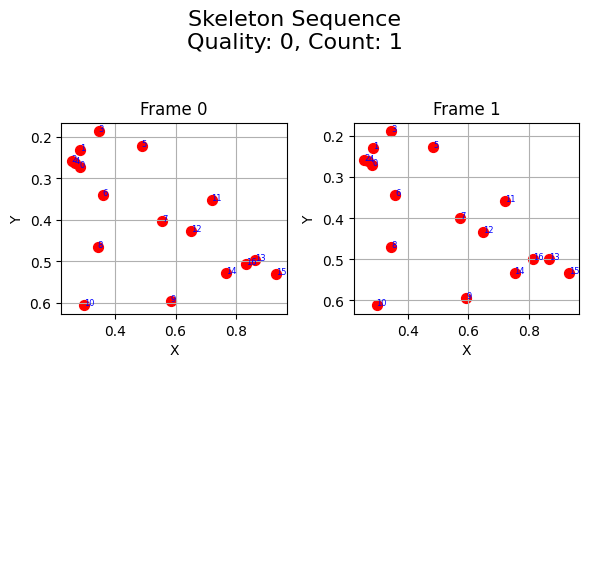

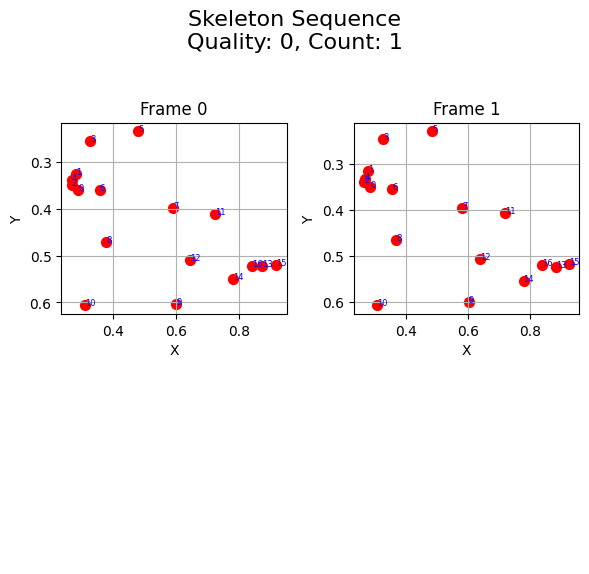

In [7]:
# 1. Подгружаем валидационный CSV
val_csv_path = r"C:\Users\jet\Desktop\видосы\np\2vr_2\skeletons_val\skeleton_records_val.csv"
val_df = pd.read_csv(val_csv_path)

# 2. (Необязательно) фильтр, если в путях действительно есть подстрока "val"
# val_df = val_df[val_df.video_path.str.contains("val")]

# 3. Создаём датасет
val_dataset = PushupPoseDatasetFromDF(val_df, seq_len=seq_len,
                                      num_joints=num_joints, normalize=True)

print(f"Validation samples: {len(val_dataset)}")   # должно быть > 0

# 4. Визуализация не больше, чем есть примеров
for i in range(min(100, len(val_dataset))):
    data_tensor, quality_label, count_label = val_dataset[i]
    visualize_skeleton_sequence(data_tensor, quality_label, count_label)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from tqdm import tqdm
import mlflow
import mlflow.pytorch

# ===================== Функция для вычисления углов =====================
def compute_angles(x):
    """
    Вычисляет геометрические признаки (углы) для каждого кадра.
    x: тензор формы (batch, seq_len, num_joints, 2)
    Возвращает тензор размера (batch, seq_len, 3)
    """

    
    l_shoulder, l_elbow, l_wrist = 5, 7, 9
    
    r_shoulder, r_elbow, r_wrist = 6, 8, 10
    
    l_hip, r_hip = 11, 12

    def angle(a, b, c):
        ba = a - b
        bc = c - b
        dot = (ba * bc).sum(dim=-1)
        cos = dot / (torch.norm(ba, dim=-1) * torch.norm(bc, dim=-1) + 1e-8)
        cos = cos.clamp(-1.0, 1.0)
        return torch.acos(cos) * 180.0 / np.pi

    a1 = x[..., l_shoulder, :]
    b1 = x[..., l_elbow, :]
    c1 = x[..., l_wrist, :]
    a2 = x[..., r_shoulder, :]
    b2 = x[..., r_elbow, :]
    c2 = x[..., r_wrist, :]
    angle1 = angle(a1, b1, c1)
    angle2 = angle(a2, b2, c2)

    mid_sh = (x[..., l_shoulder, :] + x[..., r_shoulder, :]) / 2
    mid_hp = (x[..., l_hip, :] + x[..., r_hip, :]) / 2
    torso = mid_hp - mid_sh
    horiz = torch.tensor([1.0, 0.0], device=x.device).view(1,1,2).expand_as(torso)
    dot_t = (torso * horiz).sum(dim=-1)
    cos_t = (dot_t / (torch.norm(torso, dim=-1) + 1e-8)).clamp(-1.0,1.0)
    torso_ang = torch.acos(cos_t) * 180.0 / np.pi

    return torch.stack([angle1, angle2, torso_ang], dim=-1)

# ===================== GCN-слой с learnable adjacency =====================
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, num_joints, bias=True):
        super().__init__()
        # Обучаемая матрица смежности
        self.A = nn.Parameter(torch.eye(num_joints), requires_grad=True)
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.dropout = nn.Dropout(0.2)
        # BatchNorm по фичам (out_features)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x, _=None):
        # x: (N, V, F)
        # Нормализуем A по строкам
        A = self.A / (self.A.sum(dim=1, keepdim=True) + 1e-6)
        out = torch.matmul(A, x)           # (N, V, F)
        out = self.linear(out)             # (N, V, out_features)
        # Применяем BatchNorm по каналу фич
        # Переставляем: (N, V, F_out) -> (N, F_out, V)
        out = self.bn(out.transpose(1,2)).transpose(1,2)
        out = F.relu(self.dropout(out))
        return out

# ===================== Модель Hybrid GCN + TimeSFormer =====================
class HybridGCNTimeSFormerMultiTask(nn.Module):
    def __init__(self, num_joints, in_features, gcn_hidden, num_gcn_layers,
                 d_model, seq_len, num_classes_quality, num_classes_count,
                 num_transformer_layers, nhead, dropout=0.1, d_angle=64):
        super().__init__()
        self.num_joints = num_joints
        # GCN-блок
        layers = [GCNLayer(in_features, gcn_hidden, num_joints)]
        for _ in range(num_gcn_layers-1):
            layers.append(GCNLayer(gcn_hidden, gcn_hidden, num_joints))
        self.gcn_layers = nn.ModuleList(layers)
        # Линейное преобразование GCN-выходов
        self.embedding = nn.Linear(num_joints * gcn_hidden, d_model)
        # Transformer
        self.cls_token = nn.Parameter(torch.zeros(1,1,d_model))
        self.pos_emb   = nn.Parameter(torch.zeros(1, seq_len+1, d_model))
        self.dropout   = nn.Dropout(dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
        # MLP для углов
        self.angle_mlp = nn.Sequential(
            nn.Linear(3, d_angle), nn.ReLU(), nn.Linear(d_angle, d_angle)
        )
        # Головы классификации
        self.head_quality = nn.Sequential(
            nn.LayerNorm(d_model + d_angle),
            nn.Linear(d_model + d_angle, num_classes_quality)
        )
        self.head_count   = nn.Sequential(
            nn.LayerNorm(d_model + d_angle),
            nn.Linear(d_model + d_angle, num_classes_count)
        )

    def forward(self, x, A=None):
        B, T, V, F = x.size()
        # Векторизованный GCN по кадрам
        frames = x.view(B*T, V, F)          # (B*T, V, F)
        for layer in self.gcn_layers:
            frames = layer(frames)
        # reshape вместо view для поддержки неконтiguous тензоров
        gcn_out = frames.reshape(B, T, V * self.gcn_layers[-1].linear.out_features)
        # Transformer
        x_emb = self.embedding(gcn_out)     # (B, T, d_model)
        cls   = self.cls_token.expand(B, -1, -1)
        seq   = torch.cat([cls, x_emb], dim=1) + self.pos_emb
        seq   = self.dropout(seq)
        tr_out= self.transformer(seq)
        cls_out = tr_out[:,0]
        # Угловые признаки
        angles  = compute_angles(x)         # (B, T, 3)
        ang_avg = angles.mean(dim=1)        # (B, 3)
        ang_emb = self.angle_mlp(ang_avg)   # (B, d_angle)
        # Объединяем и классифицируем
        comb = torch.cat([cls_out, ang_emb], dim=1)
        # Возвращаем логиты качества и количества сгибов
        return self.head_quality(comb), self.head_count(comb)


 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def build_adjacency(num_joints):
    A = torch.eye(num_joints)
    for i in range(num_joints - 1):
        A[i, i+1] = 1.0
        A[i+1, i] = 1.0
    A = A / A.sum(dim=1, keepdim=True)
    return A
# Матрица смежности:
A = build_adjacency(num_joints).to(device)


gcn_hidden = 64
in_features = 2
gcn_hidden = 64
num_gcn_layers = 2
d_model = 128
num_classes_quality = 3  # Классы для качества
num_classes_count = 3    # Классы для сгибов рук
num_transformer_layers = 4
nhead = 16
dropout = 0.5
d_angle = 64

model = HybridGCNTimeSFormerMultiTask(
    num_joints, 2, 64, 2, 128, seq_len, 3, 3, 4, nhead,dropout, 64
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = FocalLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


def validate(model, loader, A, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_quality = 0
    correct_count = 0
    all_true_quality = []
    all_pred_quality = []
    with torch.no_grad():
        for data, label_quality, label_count in tqdm(loader, desc="Validation", leave=False):
            data = data.to(device)
            label_quality = label_quality.to(device)
            label_count = label_count.to(device)
            logits_quality, logits_count = model(data, A)
            loss_quality = criterion(logits_quality, label_quality)
            loss_count = criterion(logits_count, label_count)
            loss = loss_quality + loss_count
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)
            _, pred_quality = torch.max(logits_quality, dim=1)
            _, pred_count = torch.max(logits_count, dim=1)
            correct_quality += (pred_quality == label_quality).sum().item()
            correct_count += (pred_count == label_count).sum().item()
            all_true_quality.extend(label_quality.cpu().numpy().tolist())
            all_pred_quality.extend(pred_quality.cpu().numpy().tolist())
    avg_loss = total_loss / total_samples
    acc_quality = correct_quality / total_samples
    acc_count = correct_count / total_samples
    # Для класса "true" (label=2) вычисляем F1
    binary_true = [1 if x == 2 else 0 for x in all_true_quality]
    binary_pred = [1 if x == 2 else 0 for x in all_pred_quality]
    f1_true = f1_score(binary_true, binary_pred, average='binary')
    overall_f1 = f1_score(all_true_quality, all_pred_quality, average='macro')
    return avg_loss, acc_quality, acc_count, f1_true, overall_f1

best_val_overall_f1 = 0.0  # переменная для хранения лучшего показателя Overall F1

mlflow.set_experiment("HybridGCNTimeSFormer_MultiTask_3")
with mlflow.start_run():
    mlflow.log_param("seq_len", seq_len)
    mlflow.log_param("num_joints", num_joints)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("gcn_hidden", gcn_hidden)
    mlflow.log_param("num_gcn_layers", num_gcn_layers)
    mlflow.log_param("d_model", d_model)
    mlflow.log_param("num_classes_quality", num_classes_quality)
    mlflow.log_param("num_classes_count", num_classes_count)
    mlflow.log_param("num_transformer_layers", num_transformer_layers)
    mlflow.log_param("nhead", nhead)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("d_angle", d_angle)
    mlflow.log_param("learning_rate", 1e-4)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False)
        for data, label_quality, label_count in train_bar:
            data = data.to(device)
            label_quality = label_quality.to(device)
            label_count = label_count.to(device)
            optimizer.zero_grad()
            logits_quality, logits_count = model(data, A)
            loss_quality = criterion(logits_quality, label_quality)
            loss_count = criterion(logits_count, label_count)
            loss = loss_quality + loss_count
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
            train_bar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f}")
        
        val_loss, val_acc_quality, val_acc_count, val_f1_true, val_overall_f1 = validate(model, val_loader, A, device)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Quality Acc: {val_acc_quality:.4f} | Count Acc: {val_acc_count:.4f} | "
              f"Val F1 for true: {val_f1_true:.4f} | Overall F1 (quality): {val_overall_f1:.4f}")
        
        mlflow.log_metric("Train Loss", epoch_loss, step=epoch)
        mlflow.log_metric("Val Loss", val_loss, step=epoch)
        mlflow.log_metric("Quality Accuracy", val_acc_quality, step=epoch)
        mlflow.log_metric("Count Accuracy", val_acc_count, step=epoch)
        mlflow.log_metric("Val_F1_for_true", val_f1_true, step=epoch)
        mlflow.log_metric("Overall_Quality_F1", val_overall_f1, step=epoch)
        
        # Сохраняем модель, если улучшился показатель Overall F1
        if val_f1_true > best_val_overall_f1:
            best_val_overall_f1 = val_f1_true
            best_model_path = "best_model_2_0_6_drop.pth"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path, artifact_path="models")
            print(f"Epoch {epoch+1}: New best Overall Quality F1: {best_val_overall_f1:.4f}. Model saved.")
    
    mlflow.pytorch.log_model(model, "final_model")

Epoch 1/200 | Train Loss: 0.3235


Epoch 1/200 | Train Loss: 0.3235 | Val Loss: 0.1953 | Quality Acc: 0.8545 | Count Acc: 0.9691 | Val F1 for true: 0.8384 | Overall F1 (quality): 0.8327
Epoch 1: New best Overall Quality F1: 0.8384. Model saved.


Epoch 2/200 | Train Loss: 0.1447


Epoch 2/200 | Train Loss: 0.1447 | Val Loss: 0.2126 | Quality Acc: 0.7933 | Count Acc: 0.9624 | Val F1 for true: 0.7347 | Overall F1 (quality): 0.7787


Epoch 3/200 | Train Loss: 0.1248


Epoch 3/200 | Train Loss: 0.1248 | Val Loss: 0.2217 | Quality Acc: 0.8032 | Count Acc: 0.9577 | Val F1 for true: 0.7109 | Overall F1 (quality): 0.7924


Epoch 4/200 | Train Loss: 0.1129


Epoch 4/200 | Train Loss: 0.1129 | Val Loss: 0.2146 | Quality Acc: 0.8038 | Count Acc: 0.9319 | Val F1 for true: 0.7878 | Overall F1 (quality): 0.7872


Epoch 5/200 | Train Loss: 0.1029


Epoch 5/200 | Train Loss: 0.1029 | Val Loss: 0.2298 | Quality Acc: 0.8037 | Count Acc: 0.9379 | Val F1 for true: 0.7599 | Overall F1 (quality): 0.7914


Epoch 6/200 | Train Loss: 0.0977


Epoch 6/200 | Train Loss: 0.0977 | Val Loss: 0.2265 | Quality Acc: 0.7915 | Count Acc: 0.9348 | Val F1 for true: 0.7353 | Overall F1 (quality): 0.7782


Epoch 7/200 | Train Loss: 0.0917


Epoch 7/200 | Train Loss: 0.0917 | Val Loss: 0.2351 | Quality Acc: 0.8001 | Count Acc: 0.9292 | Val F1 for true: 0.7764 | Overall F1 (quality): 0.7848


Epoch 8/200 | Train Loss: 0.0874


Epoch 8/200 | Train Loss: 0.0874 | Val Loss: 0.2726 | Quality Acc: 0.7783 | Count Acc: 0.9250 | Val F1 for true: 0.7451 | Overall F1 (quality): 0.7631


Epoch 9/200 | Train Loss: 0.0835


Epoch 9/200 | Train Loss: 0.0835 | Val Loss: 0.2203 | Quality Acc: 0.8586 | Count Acc: 0.9271 | Val F1 for true: 0.8554 | Overall F1 (quality): 0.8466
Epoch 9: New best Overall Quality F1: 0.8554. Model saved.


Epoch 10/200 | Train Loss: 0.0799


Epoch 10/200 | Train Loss: 0.0799 | Val Loss: 0.2479 | Quality Acc: 0.7927 | Count Acc: 0.9286 | Val F1 for true: 0.7598 | Overall F1 (quality): 0.7788


Epoch 11/200 | Train Loss: 0.0775


Epoch 11/200 | Train Loss: 0.0775 | Val Loss: 0.3307 | Quality Acc: 0.7906 | Count Acc: 0.9241 | Val F1 for true: 0.7677 | Overall F1 (quality): 0.7760


Epoch 12/200 | Train Loss: 0.0751


Epoch 12/200 | Train Loss: 0.0751 | Val Loss: 0.3664 | Quality Acc: 0.8218 | Count Acc: 0.9273 | Val F1 for true: 0.8237 | Overall F1 (quality): 0.8070


Epoch 13/200 | Train Loss: 0.0745


Epoch 13/200 | Train Loss: 0.0745 | Val Loss: 0.3549 | Quality Acc: 0.7879 | Count Acc: 0.9244 | Val F1 for true: 0.7646 | Overall F1 (quality): 0.7734


Epoch 14/200 | Train Loss: 0.0724


Epoch 14/200 | Train Loss: 0.0724 | Val Loss: 0.3096 | Quality Acc: 0.8146 | Count Acc: 0.9298 | Val F1 for true: 0.8143 | Overall F1 (quality): 0.7995


Epoch 15/200 | Train Loss: 0.0700


Epoch 15/200 | Train Loss: 0.0700 | Val Loss: 0.3890 | Quality Acc: 0.7914 | Count Acc: 0.9309 | Val F1 for true: 0.7688 | Overall F1 (quality): 0.7767


Epoch 16/200 | Train Loss: 0.0672


Epoch 16/200 | Train Loss: 0.0672 | Val Loss: 0.3359 | Quality Acc: 0.8184 | Count Acc: 0.9298 | Val F1 for true: 0.8225 | Overall F1 (quality): 0.8035


Epoch 17/200 | Train Loss: 0.0655


Epoch 17/200 | Train Loss: 0.0655 | Val Loss: 0.3916 | Quality Acc: 0.7932 | Count Acc: 0.9301 | Val F1 for true: 0.7713 | Overall F1 (quality): 0.7786


Epoch 18/200 | Train Loss: 0.0647


Epoch 18/200 | Train Loss: 0.0647 | Val Loss: 0.3911 | Quality Acc: 0.8323 | Count Acc: 0.9262 | Val F1 for true: 0.8429 | Overall F1 (quality): 0.8177


Epoch 19/200 | Train Loss: 0.0630


Epoch 19/200 | Train Loss: 0.0630 | Val Loss: 0.3809 | Quality Acc: 0.8296 | Count Acc: 0.9261 | Val F1 for true: 0.8378 | Overall F1 (quality): 0.8143


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002272C9F1E20>>
Traceback (most recent call last):
  File "C:\Users\jet\AppData\Local\anaconda3\envs\newPy\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jet\AppData\Local\anaconda3\envs\newPy\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 

KeyboardInterrupt

